In [64]:
!pip install deap
!pip install seaborn
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [65]:
import random
import numpy
import matplotlib.pyplot as plit
import scipy.io
%matplotlib inline
from deap import algorithms, base, creator, tools

In [66]:
#Define Problem:

#NUM_TASKS = 10

#TASK_POS = [[1,1], [1,2], [0,1], [3,2], [3,4], [3, 3], [7,6], [8,6], [7,8], [8, 8]]
#TASK_POS = [[1,1], [1, 2], [3,3], [6,6], [6,7]]
 #[6,4]
#ROBOT_POS = [[1,0], [3,0], [5,0], [7,0]]#, [10, 0]] #[6,4]


#ROBOT_BATTERY_CAPS = [10, 8, 6]
#TASK_PRIORITIES = [20, 30 , 40]
#TASKS_PER_ROBOT = 3

In [67]:
#dictionaries storing task and robot locations for easier access and mapping:
#this way i dont need to implement classes for tasks and robots:
#do similar for robot capacities
# how DO I AUTOMATE THIS:

#make list of task locations and use num tasks to make dict
#that adapts to nums
#add task scores, consumption, time taken as well
#HOW DO I UPDATE ROBOT BATTERY FOR EACH GENERATION
#[1,1], [1,2], [0,1], [3,2], [3,4], [3, 3], [7,6], [8,6], [7,8], [8, 8]
"""
task_dict = {
  0: [1, 1],
  1: [1, 2],
  2: [0, 1],
  3: [3, 2],
  4: [3, 4],
  5: [3, 3],
  6: [7, 6],
  7: [8, 6],
  8: [7, 8],
  9: [8, 8],
}
"""

"""
#time adjusted task_dict: --> keep task times all the same to see how the behaviour changes in terms of minimizing time without any bias
task_dict = {
    0: [[1, 1], 5],
    1: [[1, 2], 5],
    2: [[0, 1], 5],
    3: [[3, 2], 5],
    4: [[3, 4], 5],
    5: [[3, 3], 5],
    6: [[7, 6], 5],
    7: [[8, 6], 5],
    8: [[7, 8], 5],
    9: [[8, 8], 5],
}

#add robot capacities as well - minimizing distance is the same as minimizing
robot_dict = {
  1: [1, 0],
  2: [3, 0],
  3: [6, 4],
  4: [5, 6]
}
"""
NUM_ROBOTS = 4

ROBOT_POS = [[1,0], [4,0], [7,0], [10, 0]]

task_dict = {
	0: [[1, 1], 5],
	1: [[1, 2], 5],
	2: [[0, 1], 5],
	3: [[3, 2], 5],
	4: [[3, 4], 5],
	5: [[3, 3], 5],
	6: [[7, 6], 5],
	7: [[8, 6], 5],
	8: [[7, 8], 5],
	9: [[8, 8], 5],
  10: [[0, 3], 5],
  11: [[0, 4], 5],
  12: [[1, 6], 5],
  13: [[2, 6], 5],
  14: [[4, 6], 5],
  15: [[5, 3], 5],
  16: [[7, 4], 5],
  17: [[5, 7], 5],
  18: [[8, 2], 5],
  19: [[10, 4], 5],
  20: [[11, 6], 5],

}

"""
  21: [[9, 5], 5],
  22: [[0, 9], 5],
  23: [[7, 3], 5],
  24: [[11, 1], 5],
  25: [[8, 12], 5],
  26: [[12, 10], 5],
  27: [[12, 2], 5],
  28: [[12, 6], 5],
  29: [[11, 4], 5],
  30: [[8, 11], 5]
"""
#add robot capacities as well - minimizing distance is the same as minimizing
robot_dict = {
  1: [1, 0],
  2: [3, 0],
  3: [5, 0],
  4: [7, 0]
}

coordinates_list = [info[0] for info in task_dict.values()]
print(coordinates_list)
TASK_POS = coordinates_list
NUM_TASKS = len(TASK_POS)

print(NUM_TASKS)
#print(task_dict)
#print(task_dict[1]) #get [x, y] for task 1: index [0] or [1] to get x or y respectively

[[1, 1], [1, 2], [0, 1], [3, 2], [3, 4], [3, 3], [7, 6], [8, 6], [7, 8], [8, 8], [0, 3], [0, 4], [1, 6], [2, 6], [4, 6], [5, 3], [7, 4], [5, 7], [8, 2], [10, 4], [11, 6]]
21


In [68]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def create_chromosome (n, m): #n robots, m tasks
  chromosome = []

  #tasks = random.sample(range(1, m + 1), m) #create random permutation on m tasks
  tasks = random.sample(range(0, m), m) #create random permutation on m tasks
  robots = robots = [random.randint(1, n) for x in range(m)] #create random permutation of m assignments of n robots

  chromosome = tasks + robots
  return chromosome

#print(chromosome[:NUM_TASKS]) # tasks
#print(chromosome[NUM_TASKS:]) # robot assignments
#make dict of robots and tasks associated with their (x,y) coordinates

toolbox = base.Toolbox()
#toolbox.register("tasks", random.sample, range(NUM_TASKS), NUM_TASKS)
toolbox.register("chromosome", create_chromosome, NUM_ROBOTS, NUM_TASKS)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.chromosome)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [69]:
def calculate_fitness(tasks, robots):
    max_time_taken = total_time_fitness_with_return(tasks, robots, task_dict, robot_dict)
    total_distance, _ = updated_distance_fitness(tasks, robots, task_dict, robot_dict)
    return total_distance, max_time_taken

In [70]:
import math

#improved fitness function that takes going back home into account
import numpy as np
# Function to calculate Euclidean distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
# Modified fitness function for distance that takes into account the changing robot position after each task
# and the new structure of task_dict which now includes task duration
def updated_distance_fitness(tasks, robots, task_dict, robot_dict):
    total_distance = 0
    #distances_per_robot = {robot: 0 for robot in set(robots)}
    robot_positions = robot_dict.copy()  # Copy to maintain the original starting positions

    for task, robot in zip(tasks, robots):
        # Change here: Extract just the task location from the new task_dict structure
        task_location = task_dict[task][0]  # Now task_dict[task] is a list, task_location is the first element
        robot_location = robot_positions[robot]
        distance_to_task = calculate_distance(robot_location, task_location)
        total_distance += distance_to_task
        #distances_per_robot[robot] += distance_to_task  # Sum distance for each robot
        # Update the robot's position to the location of the task it just completed
        robot_positions[robot] = task_location

    # Calculate distance for each robot to return to its initial position
    for robot, initial_position in robot_dict.items():
        # Get the final position of the robot after completing all tasks
        final_position = robot_positions[robot]
        # Calculate the distance from the final position back to the initial position
        distance_to_initial_position = calculate_distance(final_position, initial_position)
        # Add this distance to the total distance and the distance for this robot
        total_distance += distance_to_initial_position
        #distances_per_robot[robot] += distance_to_initial_position

    average_distance = total_distance / len(tasks)
    return total_distance, average_distance#, distances_per_robot


#def evalSchedule(individual):
#  tasks = individual[:NUM_TASKS]
#  robots = individual[NUM_TASKS:]
#  sum = updated_distance_fitness(tasks, robots, task_dict, robot_dict)
#  return (sum,) #try dividing by tasks



# Function to calculate Euclidean distance between two points
def calculate_distance3(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Assume constant speed for simplicity
speed = 1.0  # units per time unit

def total_time_fitness_with_return(tasks, robots, task_dict, robot_dict):
    robot_positions = robot_dict.copy()  # Maintain original starting positions
    robot_end_times = {robot: 0 for robot in robot_dict}  # Track when each robot is free

    for task, robot in zip(tasks, robots):
        task_location, task_duration = task_dict[task]  # Unpacking directly from the list
        robot_location = robot_positions[robot]

        # Calculate travel time to the task
        travel_time = calculate_distance3(robot_location, task_location) / speed

        # Start time for this task
        start_time = max(robot_end_times[robot], robot_end_times[robot] + travel_time)

        # Update robot's end time after this task
        robot_end_times[robot] = start_time + task_duration

        # Update robot position
        robot_positions[robot] = task_location

    # Calculate travel time to return to initial position for each robot
    for robot, end_time in robot_end_times.items():
        initial_position = robot_dict[robot]  # Initial position of the robot
        return_travel_time = calculate_distance3(robot_positions[robot], initial_position) / speed
        robot_end_times[robot] += return_travel_time  # Add return travel time to end time

    # The fitness is the maximum of end times across all robots
    return max(robot_end_times.values())


def evalSchedule(individual):
  tasks = individual[:NUM_TASKS]
  robots = individual[NUM_TASKS:]

  max_time_taken = total_time_fitness_with_return(tasks, robots, task_dict, robot_dict)
  total_distance, average_distance= updated_distance_fitness(tasks, robots, task_dict, robot_dict)

  #COMMENT OUT ALL OTHER EXCEPT THE FUNCTION YOU WANT TO RUN

  #return (total_distance,) #F1 FUNCTION
  #return (max_time_taken,) #F2 FUNCTION

  return (0.5*max_time_taken + 0.5*total_distance,) #F3 FUNCTION

In [71]:
toolbox.register("evaluate", evalSchedule)
toolbox.register("select", tools.selTournament,tournsize=10) #3#10 did well - SO DID 20

#PARAMETER TUNING:
C1 = 0.01 # [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
M1 = 0.001 # [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
M2 = 0.001 # [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]


from deap import tools

#PMX CORSSOVER

def custom_crossover_single_child(ind1, ind2):
    # Clone the input individuals to avoid modifying the originals
    copy1, copy2 = toolbox.clone(ind1), toolbox.clone(ind2)

    # Extract the tasks halves
    tasks_half1, tasks_half2 = copy1[:NUM_TASKS], copy2[:NUM_TASKS]

    # Apply PMX only to the tasks halves and take one of the resulting halves for the child
    tasks_half_child, _ = tools.cxPartialyMatched(tasks_half1, tasks_half2) # cxUniformPartialyMatched

    new_individual = creator.Individual(tasks_half_child + copy1[NUM_TASKS:])

    return (new_individual,)



# Register the custom crossover function in the toolbox
toolbox.register("mate", custom_crossover_single_child)


#MUTATORS

toolbox.register("mutate_tasks", tools.mutShuffleIndexes, indpb=M1)
toolbox.register("mutate_robots", tools.mutUniformInt, low=1, up=NUM_ROBOTS, indpb=M2) #0.1

def mutate(individual): #THIS NEEDS TO DIRECTLY CHANGE THE IND AND NOT THE COPY - implemented (further checking needed)
    # Make a copy of the individual to avoid direct modifications
    #ind_copy = toolbox.clone(individual) #to revert just change individual with ind_copy

    # Perform mutation on the tasks half
    tasks_half = individual[:NUM_TASKS]
    mutated_tasks_half, = toolbox.mutate_tasks(tasks_half)
    individual[:NUM_TASKS] = mutated_tasks_half

    # Perform mutation on the robot assignments half
    robot_assignments_half = individual[NUM_TASKS:]
    mutated_robot_assignments_half, = toolbox.mutate_robots(robot_assignments_half)
    individual[NUM_TASKS:] = mutated_robot_assignments_half

    # Clear the fitness values of the mutated individual
    #del ind_copy.fitness.values
    #print individual

    return individual,

# Ensure the 'mutate' function is registered correctly in the toolbox
toolbox.register("mutate", mutate)

In [72]:
logbook = tools.Logbook()
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

gen	evals	avg    	std    	min    	max    
0  	300  	96.9777	4.20481	84.3026	113.716
1  	300  	90.5564	2.77512	84.3026	111.934
2  	300  	87.2835	2.79528	79.9579	106.519
3  	300  	84.6621	2.45012	79.9579	102.126
4  	300  	83.1129	2.23622	79.9579	95.8428
5  	300  	80.2983	1.74066	76.2731	101.207
6  	300  	80.0745	2.38702	76.2731	102.061
7  	300  	78.5049	1.98617	76.2731	93.6185
8  	300  	76.6164	1.30331	73.8167	90.5418
9  	300  	76.2007	1.12447	73.8167	87.1728
10 	300  	75.0877	1.63864	73.021 	87.7316
11 	300  	73.8714	0.963614	73.021 	89.5585
12 	300  	73.8743	2.0008  	71.7747	94.4253
13 	300  	73.0965	1.28802 	70.6515	90.7152
14 	300  	72.7458	1.57544 	70.6515	85.5118
15 	300  	71.6526	1.74943 	69.8876	88.4886
16 	300  	70.8454	1.60448 	69.8876	90.5234
17 	300  	70.4611	1.18546 	69.8876	84.2781
18 	300  	70.07  	1.38812 	68.9509	86.6016
19 	300  	70.0184	1.09033 	68.9509	81.7275
20 	300  	69.8133	2.06276 	68.9509	86.9775
21 	300  	69.4042	2.37469 	68.9509	88.57  
22 	300  	69.0518	0.783

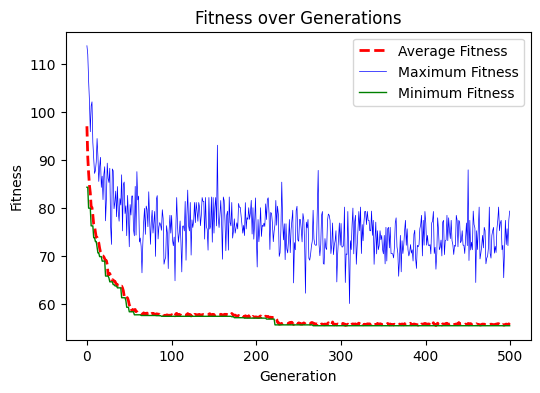

In [73]:
# 1 RUN OF THE GA + FITNESS PLOT
import matplotlib.pyplot as plt
import numpy

# Assuming you have these already defined
# toolbox, create_chromosome, etc.

# Initialize population
pop = toolbox.population(n=300) #300

# Evaluate the initial population
fitnesses = [toolbox.evaluate(ind) for ind in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# Prepare the statistics object
logbook = tools.Logbook()
logbook.header = ["gen", "evals"] + stats.fields

# Number of generations
NGEN = 500#1000#50#100 -> IMPROVEMENT IS SLOW AFTER 50 GENS
CXPB = C1 #C1 FOR PMX NOT UPMX#1.0#0.1 #0.1 -> CXPB OF 0.01 and MUTPB OF 0.1 Produced interesting results
MUTPB = 1.0#0.1 #0.1#0.2 - 0.5 did wose on avg fitness but still produced best result - most solutions arent good - but didnt check diversity
#0.001 - max fitness decreases


for gen in range(NGEN):
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))

    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace population
    pop[:] = offspring

    # Update the statistics with the new population
    record = stats.compile(pop)
    logbook.record(gen=gen, evals=len(invalid_ind), **record)

    print(logbook.stream)

    #print best individual per generation
    #indv = tools.selBest(pop, 1)[0]
    #print(indv)

# Extract statistics
gen = logbook.select("gen")
avg_fit = logbook.select("avg")
max_fit = logbook.select("max")
min_fit = logbook.select("min")


# Plotting
plt.figure(figsize=(6,4))
plt.plot(gen, avg_fit, label="Average Fitness", linewidth=2, color='red', linestyle='--')
plt.plot(gen, max_fit, label="Maximum Fitness", linewidth=0.5, color='blue')
plt.plot(gen, min_fit, label="Minimum Fitness",linewidth=1, color='green')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="best")
plt.title("Fitness over Generations")
plt.show()




In [74]:
ind = tools.selBest(pop, 1)[0]
print(ind)


[3, 7, 19, 9, 2, 8, 20, 10, 17, 11, 5, 15, 6, 4, 16, 14, 1, 13, 12, 0, 18, 2, 4, 3, 4, 1, 4, 3, 1, 3, 1, 2, 3, 4, 2, 4, 2, 1, 2, 2, 1, 4]


In [75]:
F1_50_distances = [55.26329615197943, 54.31842757170952, 61.089013673960935, 64.36659899287702, 66.81293746324963, 68.87258366835795, 56.84076056050173, 57.49425502336722, 56.55911509267041, 67.22863657541825, 65.89807603950011, 60.91609439316222, 69.15441057004757, 58.10354328405845, 56.76758556614473, 64.34544890957096, 70.31755799579128, 62.26594145776451, 63.243976297282885, 52.34867335213044, 58.749881201820585, 54.71615768666859, 66.29313916516735, 57.79973347504272, 60.96714424784067, 64.42732224900794, 65.2914054788846, 64.25930947854691, 58.36513537264395, 68.41554917253671, 52.164094764193685, 55.00994141991137, 64.8231026832732, 58.61788471121953, 59.762322619966405, 54.7316438566393, 60.654887205835124, 60.15066013238783, 64.93563419742357, 55.43731169920737, 68.72471362874951, 62.80837519838777, 55.80581592870492, 59.972803760081376, 57.4196383669637, 71.8427759350959, 57.697958525603596, 79.06151419337172, 59.57745599620533, 69.42243236082435]
F1_50_best_inds = [[15, 12, 13, 14, 0, 17, 7, 19, 1, 20, 9, 8, 4, 6, 11, 10, 16, 2, 5, 18, 3, 4, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 4, 3, 1, 1, 3, 1, 4, 3, 4], [15, 1, 9, 16, 5, 4, 8, 11, 17, 6, 14, 13, 10, 7, 20, 2, 12, 19, 0, 18, 3, 3, 1, 3, 4, 1, 1, 3, 1, 3, 4, 3, 3, 1, 4, 4, 1, 3, 4, 1, 4, 3], [3, 13, 6, 5, 12, 7, 4, 11, 14, 8, 9, 17, 10, 18, 20, 19, 15, 1, 2, 0, 16, 2, 1, 3, 2, 1, 3, 2, 1, 2, 3, 3, 2, 1, 4, 3, 3, 2, 2, 1, 2, 3], [5, 10, 4, 1, 11, 18, 19, 20, 14, 2, 13, 12, 3, 17, 9, 8, 0, 6, 16, 7, 15, 3, 1, 3, 2, 1, 4, 4, 4, 1, 2, 3, 3, 3, 1, 4, 4, 2, 1, 1, 4, 1], [5, 2, 17, 10, 16, 11, 18, 12, 7, 6, 15, 14, 3, 19, 13, 20, 4, 9, 0, 8, 1, 2, 1, 2, 1, 3, 1, 4, 1, 3, 3, 3, 2, 3, 4, 1, 4, 2, 4, 1, 4, 2], [16, 1, 14, 3, 0, 5, 2, 17, 4, 7, 8, 13, 12, 9, 6, 11, 15, 10, 20, 19, 18, 3, 1, 1, 4, 2, 4, 2, 1, 4, 3, 1, 4, 4, 1, 3, 4, 3, 4, 1, 1, 1], [12, 13, 14, 17, 18, 19, 6, 15, 0, 20, 9, 8, 7, 4, 2, 5, 10, 16, 3, 11, 1, 1, 1, 1, 1, 3, 3, 1, 1, 2, 3, 3, 3, 3, 1, 2, 1, 2, 3, 1, 2, 2], [3, 0, 15, 16, 5, 2, 6, 7, 4, 20, 14, 19, 9, 8, 17, 13, 10, 18, 1, 12, 11, 2, 3, 4, 4, 2, 3, 4, 4, 2, 4, 2, 4, 2, 2, 2, 2, 3, 4, 3, 2, 2], [10, 14, 11, 7, 17, 12, 6, 13, 8, 4, 9, 5, 3, 1, 16, 2, 15, 20, 0, 19, 18, 2, 3, 2, 4, 3, 2, 3, 2, 4, 2, 4, 2, 2, 2, 3, 2, 3, 4, 2, 4, 4], [12, 18, 20, 1, 7, 11, 13, 9, 8, 14, 10, 6, 16, 17, 19, 4, 2, 0, 15, 3, 5, 1, 4, 4, 2, 3, 2, 1, 3, 3, 1, 2, 1, 1, 3, 4, 3, 2, 2, 1, 1, 3], [5, 4, 12, 0, 1, 6, 13, 14, 19, 17, 16, 8, 15, 9, 20, 11, 10, 2, 3, 18, 7, 3, 3, 3, 1, 1, 2, 3, 3, 4, 3, 3, 2, 3, 2, 4, 1, 1, 1, 3, 4, 2], [15, 5, 0, 4, 3, 14, 1, 13, 17, 16, 2, 6, 20, 8, 19, 18, 9, 12, 7, 11, 10, 3, 3, 1, 3, 2, 3, 1, 2, 3, 4, 1, 4, 3, 4, 3, 3, 4, 2, 4, 2, 2], [15, 10, 5, 4, 13, 11, 18, 19, 20, 12, 7, 14, 6, 17, 1, 2, 8, 9, 3, 0, 16, 4, 1, 4, 4, 4, 1, 2, 2, 2, 1, 2, 4, 2, 1, 2, 2, 1, 1, 1, 2, 4], [12, 18, 13, 3, 16, 19, 20, 1, 7, 17, 6, 11, 10, 8, 2, 9, 0, 14, 4, 5, 15, 1, 4, 1, 2, 4, 4, 4, 2, 4, 1, 4, 2, 2, 1, 2, 1, 2, 1, 1, 1, 4], [17, 2, 18, 10, 8, 19, 20, 11, 1, 9, 14, 13, 7, 12, 0, 6, 4, 16, 15, 3, 5, 2, 1, 4, 1, 2, 4, 4, 1, 1, 2, 4, 4, 2, 4, 1, 2, 4, 2, 2, 2, 4], [0, 17, 8, 3, 1, 9, 18, 10, 2, 20, 7, 19, 6, 16, 14, 11, 15, 13, 5, 12, 4, 1, 2, 2, 3, 3, 2, 4, 3, 1, 2, 4, 2, 4, 2, 4, 3, 2, 4, 3, 4, 4], [9, 8, 18, 19, 17, 3, 0, 14, 16, 1, 5, 20, 12, 15, 7, 13, 6, 11, 4, 10, 2, 3, 3, 2, 2, 3, 4, 1, 3, 3, 1, 4, 2, 4, 3, 2, 4, 2, 1, 4, 1, 1], [18, 15, 0, 19, 16, 1, 6, 20, 17, 10, 14, 11, 8, 9, 4, 13, 5, 12, 3, 7, 2, 4, 1, 3, 1, 4, 3, 4, 1, 1, 3, 1, 3, 4, 4, 3, 1, 3, 1, 3, 4, 1], [18, 0, 19, 3, 5, 1, 4, 6, 7, 9, 20, 16, 2, 10, 11, 8, 12, 13, 17, 14, 15, 3, 1, 3, 4, 1, 4, 1, 1, 1, 1, 3, 3, 4, 4, 4, 1, 4, 4, 1, 1, 4], [4, 13, 12, 11, 10, 18, 16, 19, 20, 1, 5, 0, 7, 6, 3, 9, 2, 8, 17, 14, 15, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 1, 2, 2, 3, 2, 1, 2, 2, 2, 2], [6, 15, 5, 9, 8, 17, 4, 11, 14, 10, 13, 2, 16, 0, 1, 7, 12, 20, 19, 18, 3, 1, 4, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 4, 2, 2, 4, 1, 4, 4, 4, 2], [3, 5, 4, 16, 0, 14, 17, 2, 10, 11, 12, 13, 8, 9, 7, 20, 19, 1, 18, 15, 6, 2, 2, 2, 3, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 3, 2, 2, 1, 2, 2, 3], [18, 1, 0, 10, 19, 20, 13, 11, 4, 12, 5, 2, 8, 9, 15, 7, 14, 17, 6, 3, 16, 4, 3, 1, 3, 4, 4, 4, 3, 3, 4, 3, 1, 4, 4, 3, 4, 3, 3, 3, 2, 3], [13, 15, 5, 4, 14, 17, 12, 11, 8, 0, 1, 18, 20, 10, 9, 19, 7, 2, 6, 16, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2, 4, 4, 1, 3, 4, 3, 1, 3, 3, 2], [18, 15, 11, 12, 13, 16, 4, 14, 5, 0, 17, 6, 7, 20, 2, 10, 3, 8, 19, 9, 1, 4, 3, 1, 1, 1, 4, 1, 3, 1, 2, 3, 4, 4, 4, 2, 2, 1, 3, 4, 3, 2], [18, 6, 9, 8, 17, 19, 20, 7, 1, 14, 11, 10, 13, 2, 0, 16, 15, 3, 12, 4, 5, 1, 4, 4, 4, 4, 1, 1, 1, 3, 4, 3, 3, 4, 3, 3, 1, 1, 1, 4, 4, 4], [15, 19, 14, 20, 13, 16, 9, 8, 0, 17, 11, 10, 2, 12, 6, 1, 4, 7, 5, 18, 3, 3, 1, 3, 1, 3, 4, 1, 1, 2, 1, 1, 1, 1, 3, 4, 2, 3, 4, 3, 4, 3], [6, 15, 7, 2, 10, 9, 11, 12, 13, 8, 17, 20, 14, 5, 16, 4, 1, 18, 0, 3, 19, 4, 2, 2, 1, 1, 4, 1, 1, 1, 4, 4, 2, 4, 3, 4, 1, 1, 4, 1, 3, 2], [15, 18, 4, 10, 16, 7, 9, 11, 3, 5, 12, 8, 6, 13, 14, 1, 17, 20, 2, 0, 19, 3, 4, 3, 3, 4, 4, 4, 3, 2, 2, 3, 4, 4, 3, 3, 2, 3, 3, 2, 2, 3], [14, 18, 19, 1, 17, 6, 20, 11, 3, 16, 15, 5, 10, 12, 7, 9, 2, 13, 8, 0, 4, 1, 4, 4, 2, 1, 1, 4, 2, 3, 4, 4, 3, 2, 3, 1, 1, 2, 3, 1, 2, 3], [3, 6, 9, 2, 15, 16, 8, 7, 20, 17, 14, 10, 11, 1, 13, 19, 12, 4, 5, 0, 18, 2, 2, 2, 1, 3, 3, 2, 3, 3, 2, 2, 1, 1, 1, 2, 3, 2, 2, 2, 1, 3], [6, 8, 3, 17, 16, 14, 1, 7, 11, 9, 13, 12, 4, 5, 10, 15, 20, 2, 0, 19, 18, 3, 3, 1, 3, 4, 3, 1, 4, 1, 4, 3, 3, 3, 3, 1, 3, 4, 1, 1, 4, 4], [5, 1, 3, 13, 6, 12, 7, 8, 9, 11, 4, 14, 17, 10, 18, 20, 19, 16, 2, 15, 0, 3, 1, 2, 2, 1, 2, 1, 1, 1, 2, 3, 3, 3, 2, 4, 1, 1, 1, 2, 3, 2], [16, 19, 20, 3, 9, 8, 17, 2, 10, 5, 11, 1, 14, 18, 4, 6, 7, 15, 13, 12, 0, 3, 3, 3, 2, 3, 3, 3, 1, 1, 2, 1, 1, 3, 4, 2, 2, 2, 2, 3, 3, 1], [2, 12, 10, 13, 14, 7, 8, 17, 9, 11, 4, 20, 6, 19, 15, 16, 5, 1, 0, 3, 18, 1, 1, 2, 1, 1, 3, 3, 1, 3, 2, 2, 3, 1, 3, 1, 3, 2, 1, 1, 2, 3], [16, 0, 3, 1, 5, 4, 12, 6, 17, 11, 10, 13, 8, 9, 14, 7, 2, 20, 19, 15, 18, 4, 1, 2, 1, 2, 2, 2, 4, 4, 1, 1, 2, 2, 2, 4, 2, 1, 2, 2, 4, 2], [15, 0, 19, 1, 20, 5, 4, 14, 7, 17, 13, 8, 12, 18, 9, 6, 3, 11, 10, 16, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 4, 1, 1, 1, 2, 2, 4, 2], [15, 2, 3, 14, 18, 9, 10, 17, 6, 11, 1, 0, 8, 7, 16, 12, 13, 4, 20, 5, 19, 3, 1, 2, 3, 4, 4, 2, 3, 3, 2, 1, 1, 4, 3, 4, 2, 2, 2, 3, 2, 3], [4, 15, 5, 0, 16, 13, 12, 14, 11, 20, 19, 17, 8, 10, 18, 1, 2, 3, 9, 7, 6, 4, 2, 3, 1, 2, 4, 4, 3, 4, 2, 2, 3, 3, 4, 2, 4, 1, 4, 3, 3, 3], [16, 18, 19, 6, 9, 20, 8, 7, 2, 17, 14, 13, 15, 12, 10, 11, 4, 5, 1, 0, 3, 2, 3, 3, 2, 2, 3, 2, 3, 1, 3, 3, 3, 2, 3, 1, 1, 3, 3, 1, 1, 3], [18, 3, 15, 6, 17, 0, 5, 8, 16, 20, 4, 9, 19, 7, 13, 14, 12, 11, 10, 1, 2, 4, 2, 2, 4, 3, 1, 1, 4, 2, 2, 1, 4, 2, 4, 1, 3, 1, 1, 1, 1, 1], [14, 5, 18, 17, 19, 8, 10, 0, 3, 20, 11, 1, 9, 6, 16, 2, 12, 13, 15, 7, 4, 2, 3, 4, 2, 4, 2, 3, 1, 1, 4, 3, 1, 2, 2, 2, 1, 3, 3, 2, 4, 3], [2, 16, 11, 14, 10, 12, 4, 17, 6, 7, 8, 9, 20, 15, 19, 5, 13, 1, 0, 18, 3, 1, 4, 2, 4, 1, 2, 1, 4, 4, 4, 4, 4, 4, 1, 4, 1, 2, 1, 1, 4, 2], [0, 2, 19, 1, 10, 7, 11, 9, 8, 12, 13, 3, 6, 14, 17, 20, 18, 15, 4, 5, 16, 1, 1, 4, 1, 1, 3, 1, 3, 3, 1, 1, 2, 3, 1, 1, 4, 4, 1, 1, 1, 3], [16, 15, 6, 14, 2, 17, 10, 7, 11, 20, 12, 9, 19, 13, 4, 8, 5, 1, 18, 0, 3, 2, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 2, 3, 1, 1, 2, 2, 1, 3, 1, 2], [5, 15, 3, 16, 10, 1, 7, 14, 9, 17, 8, 2, 11, 12, 6, 13, 20, 0, 19, 18, 4, 2, 3, 4, 3, 1, 4, 3, 2, 3, 2, 2, 4, 1, 1, 3, 1, 2, 4, 2, 2, 1], [16, 6, 18, 7, 5, 4, 13, 12, 11, 10, 17, 1, 8, 9, 2, 20, 19, 0, 14, 15, 3, 2, 2, 3, 3, 1, 1, 1, 1, 1, 1, 2, 1, 3, 3, 1, 3, 3, 1, 2, 2, 2], [19, 17, 8, 20, 9, 16, 18, 7, 3, 1, 13, 2, 12, 0, 10, 15, 6, 14, 4, 11, 5, 3, 1, 1, 3, 1, 3, 4, 1, 3, 3, 4, 2, 4, 3, 2, 4, 1, 1, 1, 2, 1], [0, 14, 18, 3, 5, 1, 17, 13, 4, 12, 16, 11, 8, 9, 15, 6, 7, 10, 20, 19, 2, 1, 2, 4, 3, 3, 1, 2, 1, 3, 1, 4, 1, 2, 2, 3, 2, 2, 1, 2, 2, 1], [7, 0, 1, 2, 6, 3, 17, 4, 10, 15, 5, 11, 12, 13, 14, 19, 16, 20, 18, 9, 8, 3, 1, 1, 1, 3, 4, 3, 3, 4, 2, 3, 4, 4, 4, 4, 2, 4, 2, 4, 2, 2]]

min_distance = min(F1_50_distances)
print(min_distance)
print(F1_50_distances.index(min_distance))

ind_main = F1_50_best_inds[30]
print(ind_main)

print(np.std(F1_50_best_inds))

52.164094764193685
30
[3, 6, 9, 2, 15, 16, 8, 7, 20, 17, 14, 10, 11, 1, 13, 19, 12, 4, 5, 0, 18, 2, 2, 2, 1, 3, 3, 2, 3, 3, 2, 2, 1, 1, 1, 2, 3, 2, 2, 2, 1, 3]
5.777789987777086


In [76]:
#RUN OUR GA FOR 50 RUNS TO OBTAIN DATA

#COMMENTED OUT AS TAKES A WHILE TO RUN IF ACCIDENTALLY RUN
"""


import numpy as np
from deap import tools

# Assume the rest of your GA setup is already defined above this point

def run_ga():
    # Initialize population
    pop = toolbox.population(n=300)  # Adjust your population size as needed

    # Evaluate the initial population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    # Begin the evolution
    for gen in range(NGEN):  # NGEN is the number of generations
        # ... the rest of your GA loop ...
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))

        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Replace population
        pop[:] = offspring

        # Update the statistics with the new population
        #record = stats.compile(pop)
        #logbook.record(gen=gen, evals=len(invalid_ind), **record)

        #print(logbook.stream)

        #print best individual per generation
        #indv = tools.selBest(pop, 1)[0]
        #print(indv)


    # Select the best individual
    best_ind = tools.selBest(pop, 1)[0]
    return best_ind, pop

#main_distances = []
#main_times = []
#main_best_inds = []

def calculate_averages(n_runs=10):
    distances = []
    times = []
    best_inds = []
    all_pops = []

    for _ in range(n_runs):
        best_ind, pop = run_ga()

        tasks = best_ind[:NUM_TASKS]
        robots = best_ind[NUM_TASKS:]

        # Assuming these functions are defined and work as expected
        max_time_taken = total_time_fitness_with_return(tasks, robots, task_dict, robot_dict)
        total_distance, average_distance = updated_distance_fitness(tasks, robots, task_dict, robot_dict)

        distances.append(total_distance)
        times.append(max_time_taken)
        best_inds.append(best_ind)
        all_pops.append(pop)

    avg_distance = np.mean(distances)
    avg_max_time_taken = np.mean(times)

    #print(distances)
    #print(times)
    #print(best_inds)
    #print(len(all_pops))

    #main_distances = distances
    #main_times = times
    #main_best_inds = best_inds

    return avg_distance, avg_max_time_taken, distances, times, best_inds, all_pops

# Run the genetic algorithm multiple times and get the average metrics

average_distance, average_max_time_taken, distances1, times1, best_inds1, all_pops1  = calculate_averages()
print(f'avg_distance: {average_distance}')
print(f'avg_time: {average_max_time_taken}')

avg_fitness = ((0.5*average_distance) + (0.5*average_max_time_taken))
print(f'fitness: {avg_fitness}')

print(f'distances: {distances1}') # best distances from the 10 runs
print(f'times: {times1}') # best times from the 10 runs
print(f'best individuals: {best_inds1}')
print(f'std distances: {np.std(distances1)}') # best distances from the 10 runs
print(f'std times: {np.std(times1)}') # best times from the 10 runs
print(len(all_pops1)) # should be 10
"""

# COPY THESE RAW VALUES FROM BELOW



"\n\n\nimport numpy as np\nfrom deap import tools\n\n# Assume the rest of your GA setup is already defined above this point\n\ndef run_ga():\n    # Initialize population\n    pop = toolbox.population(n=300)  # Adjust your population size as needed\n\n    # Evaluate the initial population\n    fitnesses = list(map(toolbox.evaluate, pop))\n    for ind, fit in zip(pop, fitnesses):\n        ind.fitness.values = fit\n\n    # Begin the evolution\n    for gen in range(NGEN):  # NGEN is the number of generations\n        # ... the rest of your GA loop ...\n        # Select the next generation individuals\n        offspring = toolbox.select(pop, len(pop))\n\n        # Clone the selected individuals\n        offspring = list(map(toolbox.clone, offspring))\n\n        # Apply crossover and mutation on the offspring\n        for child1, child2 in zip(offspring[::2], offspring[1::2]):\n            if random.random() < CXPB:\n                toolbox.mate(child1, child2)\n                del child1.fi

In [77]:
"""
# Your code to generate the list

# Save the list to a text file
with open('2PMX_F2_50_POPS_T10_M1M20_001_C10.01PMX.txt', 'w') as f:
    for pop in all_pops1:
        f.write(f"{pop}\n")

"""
# SAVE FULL POPULATION IF DESIRED

'\n# Your code to generate the list\n\n# Save the list to a text file\nwith open(\'2PMX_F2_50_POPS_T10_M1M20_001_C10.01PMX.txt\', \'w\') as f:\n    for pop in all_pops1:\n        f.write(f"{pop}\n")\n\n'

In [78]:
#OLD RAW DATA FROM 10 RUNS DO NOT USE
"""
F2_avg_distance = 81.16409242599919
F2_avg_time = 47.007278576093924
F2_distances = [86.19856555120128, 80.43836611256584, 85.37836353417813, 88.40915513171262, 71.18273541180999, 77.37637172278788, 70.72751753626538, 82.36100321618459, 74.53518235253847, 95.03366369074755]
F2_times = [48.41640786499873, 46.569298810733386, 48.449659909380486, 48.49171435515375, 44.84161925296378, 45.758533720546936, 44.11141944739755, 47.47603286813174, 45.488674784415295, 50.469424747217566]
F2_best_inds = [
[6, 3, 16, 2, 0, 7, 9, 20, 1, 8, 14, 10, 17, 13, 5, 4, 19, 18, 12, 11, 15, 4, 2, 3, 1, 2, 3, 4, 3, 1, 3, 4, 1, 3, 4, 4, 1, 2, 2, 1, 1, 2],
[1, 3, 6, 0, 4, 14, 12, 5, 8, 9, 15, 20, 17, 18, 7, 13, 19, 16, 11, 10, 2, 4, 2, 3, 1, 1, 1, 2, 4, 3, 3, 4, 3, 1, 1, 4, 2, 3, 4, 2, 2, 2],
[13, 18, 3, 19, 17, 12, 8, 14, 1, 4, 5, 7, 11, 20, 16, 10, 2, 9, 6, 0, 15, 3, 1, 2, 4, 2, 3, 3, 2, 2, 1, 1, 4, 1, 4, 3, 1, 2, 4, 4, 2, 3],
[18, 1, 3, 2, 16, 8, 4, 14, 11, 17, 10, 12, 6, 19, 20, 9, 0, 7, 15, 13, 5, 2, 1, 4, 1, 3, 3, 1, 3, 4, 4, 3, 1, 4, 2, 2, 2, 3, 4, 2, 1, 1],
[19, 5, 0, 4, 3, 20, 13, 12, 11, 14, 10, 17, 9, 6, 7, 15, 8, 16, 18, 1, 2, 4, 3, 1, 1, 2, 4, 1, 1, 1, 3, 1, 3, 4, 3, 3, 2, 4, 4, 2, 2, 2],
[2, 13, 0, 12, 1, 4, 8, 10, 6, 19, 3, 14, 7, 9, 11, 20, 17, 18, 5, 15, 16, 2, 3, 1, 3, 2, 1, 1, 2, 1, 4, 1, 3, 4, 4, 2, 4, 3, 4, 2, 2, 3],
[5, 19, 20, 12, 11, 10, 2, 17, 7, 8, 16, 3, 9, 4, 1, 13, 15, 6, 18, 0, 14, 1, 3, 3, 1, 1, 1, 2, 4, 3, 4, 3, 2, 4, 2, 1, 2, 3, 4, 4, 1, 2],
[4, 10, 11, 5, 18, 19, 20, 16, 7, 9, 13, 12, 17, 3, 6, 1, 0, 8, 2, 14, 15, 3, 2, 2, 2, 4, 1, 1, 4, 4, 1, 3, 3, 3, 2, 4, 2, 1, 3, 2, 4, 4],
[18, 14, 8, 5, 4, 11, 10, 17, 12, 13, 1, 2, 6, 9, 20, 7, 0, 19, 16, 15, 3, 4, 2, 4, 3, 3, 3, 3, 2, 2, 2, 3, 1, 1, 4, 4, 1, 3, 4, 1, 1, 2],
[14, 16, 18, 12, 0, 3, 17, 1, 10, 11, 5, 13, 6, 8, 9, 20, 7, 4, 19, 2, 15, 1, 4, 4, 1, 3, 2, 2, 3, 4, 4, 3, 1, 1, 2, 2, 3, 2, 1, 3, 4, 2]
]

F1_avg_distance = 60.47772168659062
F1_avg_time: 68.6898978324748
F1_distances =  [52.475504665291446, 52.618865384703476, 67.02280719911283, 74.42354819952268, 55.4942550233672, 70.00866487908489, 58.769779868770364, 58.87551159753735, 64.02698894559764, 51.06129110291835]
F1_times = [88.03275925283612, 66.52076313254062, 64.77728407862269, 54.679018590676776, 69.0871423734539, 65.89024643050483, 64.05280892402587, 75.19601007683706, 56.30056307974577, 82.36238238550442]
F1_best_inds = [
[4, 18, 14, 6, 19, 20, 0, 1, 7, 10, 16, 9, 8, 17, 13, 12, 11, 2, 5, 15, 3, 2, 4, 2, 2, 4, 4, 1, 1, 2, 1, 4, 2, 2, 2, 2, 2, 2, 1, 2, 4, 2],
[2, 5, 14, 10, 11, 17, 12, 8, 9, 13, 4, 18, 6, 19, 1, 16, 15, 3, 0, 20, 7, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 4, 2, 4, 1, 2, 2, 2, 1, 4, 4],
[1, 19, 15, 18, 16, 17, 20, 14, 10, 13, 3, 7, 4, 9, 5, 2, 12, 11, 8, 0, 6, 3, 4, 1, 1, 1, 1, 4, 1, 3, 1, 2, 4, 2, 4, 2, 3, 1, 1, 4, 3, 4],
[0, 14, 7, 17, 8, 2, 12, 1, 9, 20, 19, 10, 11, 5, 15, 13, 18, 6, 4, 3, 16, 4, 1, 3, 1, 1, 4, 2, 4, 1, 3, 3, 4, 4, 4, 4, 2, 3, 1, 2, 2, 1],
[4, 14, 0, 2, 16, 17, 8, 20, 10, 11, 12, 13, 9, 7, 6, 5, 3, 15, 19, 1, 18, 1, 1, 2, 2, 4, 1, 1, 4, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 4, 1, 4],
[18, 3, 5, 14, 0, 1, 10, 17, 11, 7, 13, 8, 12, 9, 2, 6, 20, 19, 16, 15, 4, 4, 2, 2, 2, 1, 3, 3, 2, 3, 3, 4, 2, 4, 2, 1, 2, 3, 3, 2, 2, 4],
[18, 3, 19, 0, 20, 2, 7, 6, 16, 9, 5, 10, 11, 12, 13, 14, 1, 4, 8, 15, 17, 4, 2, 4, 1, 4, 1, 4, 4, 3, 4, 2, 1, 1, 1, 1, 1, 2, 1, 4, 3, 4],
[18, 3, 15, 9, 0, 8, 16, 2, 17, 19, 14, 13, 20, 7, 12, 11, 1, 10, 4, 6, 5, 4, 2, 2, 2, 3, 2, 4, 3, 2, 4, 2, 2, 4, 4, 2, 2, 3, 2, 3, 4, 3],
[6, 8, 9, 0, 2, 3, 10, 14, 7, 5, 4, 15, 11, 12, 20, 19, 13, 18, 1, 16, 17, 4, 4, 4, 1, 1, 2, 1, 2, 4, 3, 3, 3, 1, 1, 4, 4, 1, 4, 1, 3, 2],
[18, 16, 19, 4, 0, 1, 13, 20, 7, 6, 5, 12, 9, 8, 17, 11, 14, 10, 3, 2, 15, 4, 4, 4, 2, 1, 1, 2, 4, 4, 4, 1, 2, 4, 4, 4, 2, 4, 2, 1, 2, 4]
]

F3_avg_distance: 70.14120354096167
F3_avg_time: 46.923139476253695
F3_distances = [67.39843468830965, 66.99715364179582, 66.80093917481626, 78.3892193510626, 75.21099681781287, 70.44607871145251, 72.11462767937762, 61.73386227287571, 67.85758914773703, 74.46313392437659]
F3_times  = [44.79217466001559, 46.556395895082645, 45.18021459859887, 52.493414690699595, 47.36505818199175, 48.59625606037856, 45.90339184974382, 46.10654957016754, 45.18021459859887, 47.05772465725966]
F3_best_inds= [
[1, 19, 4, 2, 20, 10, 3, 14, 7, 5, 8, 11, 16, 12, 18, 9, 13, 17, 6, 0, 15, 2, 4, 2, 1, 4, 1, 3, 2, 4, 3, 3, 1, 4, 1, 4, 3, 1, 2, 3, 1, 2],
[2, 10, 11, 0, 12, 1, 19, 15, 20, 13, 16, 4, 7, 14, 9, 8, 3, 18, 6, 17, 5, 2, 2, 2, 1, 2, 1, 4, 3, 4, 2, 3, 1, 3, 1, 4, 4, 2, 3, 4, 1, 1],
[16, 15, 7, 3, 6, 5, 20, 9, 1, 10, 8, 2, 4, 19, 18, 13, 17, 12, 0, 11, 14, 4, 3, 4, 1, 2, 1, 4, 2, 3, 3, 2, 3, 1, 4, 4, 1, 2, 1, 3, 1, 2],
[15, 17, 16, 5, 14, 6, 1, 2, 0, 8, 4, 10, 13, 11, 7, 20, 9, 18, 19, 12, 3, 3, 3, 4, 2, 3, 4, 3, 3, 3, 4, 2, 1, 2, 1, 1, 1, 4, 4, 1, 2, 2],
[3, 19, 15, 16, 13, 20, 6, 0, 5, 8, 4, 9, 12, 7, 14, 11, 18, 10, 1, 2, 17, 2, 1, 3, 4, 3, 1, 4, 1, 2, 4, 2, 4, 3, 4, 2, 3, 4, 3, 3, 1, 2],
[5, 1, 11, 10, 2, 0, 3, 4, 17, 18, 8, 12, 13, 14, 9, 15, 19, 20, 7, 6, 16, 4, 2, 2, 2, 2, 2, 1, 4, 1, 3, 1, 4, 4, 4, 1, 4, 3, 3, 3, 1, 3],
[1, 11, 15, 10, 4, 7, 12, 13, 6, 2, 9, 0, 20, 8, 16, 19, 17, 14, 3, 18, 5, 2, 2, 3, 2, 3, 4, 3, 3, 1, 2, 4, 2, 4, 1, 3, 4, 1, 1, 2, 4, 1],
[10, 6, 11, 3, 18, 16, 9, 8, 17, 7, 12, 13, 5, 14, 1, 2, 20, 19, 15, 4, 0, 1, 3, 1, 2, 4, 4, 3, 3, 3, 4, 1, 1, 2, 1, 2, 2, 4, 4, 3, 1, 2],
[2, 15, 4, 10, 11, 5, 1, 16, 6, 7, 9, 20, 8, 17, 12, 19, 14, 13, 3, 18, 0, 1, 4, 4, 1, 1, 4, 4, 3, 2, 3, 2, 3, 2, 2, 1, 3, 2, 1, 4, 3, 1],
[2, 18, 16, 10, 19, 4, 20, 9, 11, 14, 12, 15, 8, 13, 7, 17, 5, 3, 6, 1, 0, 1, 2, 2, 3, 4, 1, 4, 4, 3, 1, 3, 2, 4, 3, 4, 1, 3, 3, 1, 2, 2]]
"""
F3_50_avg_distances = 68.69912997011373
F3_50_time = 47.61547206101054

F3_50_distances = [76.81839773380894, 63.5680453406986, 61.45391192804776, 63.19535660724496, 64.17160477094095, 62.023418381481605, 70.5739935465768, 64.94341299565414, 79.26809527597906, 65.46900038422855, 73.11944169043699, 65.82314331631171, 75.12598616765807, 71.38401830196555, 69.66192662300027, 63.36437895276322, 67.7666472410517, 73.5835836698829, 85.43636726974553, 65.22789243510728, 59.54422717029132, 70.13053099322893, 68.21753224611327, 72.19189415761645, 62.17071418279178, 67.00932171772276, 65.31071075308829, 72.04403372134674, 72.70046585480793, 72.95909472670743, 64.98315939161688, 73.00120594204934, 64.60607760658795, 62.3314944331753, 75.17603655443389, 73.76692719184854, 74.34023527781592, 64.29244332503606, 68.3137999143593, 66.41079451384499, 68.68003450659992, 77.9794111087057, 71.8208036971068, 62.52387138871802, 74.24959404301146, 69.15142018174734, 66.3959895354213, 59.562487110840436, 60.645249641138655, 72.46831498532977]

F3_50_times = [47.035104559701715, 44.07768723046357, 50.313755207963354, 43.79669127533634, 52.48081146789641, 45.708203932499366, 46.95517997529072, 44.96334839520807, 47.142182332709545, 46.935664825658925, 47.07983482411061, 47.07983482411061, 49.916235337412914, 45.185939411137625, 52.21986956317312, 51.425505344717344, 50.224944863007764, 47.077316341162415, 49.33859534563509, 47.82842712474619, 45.56062329783654, 49.14218233270955, 45.160449760761786, 47.64098632478745, 50.313755207963354, 46.569298810733386, 44.96334839520808, 47.236067977499786, 47.5548984852978, 46.39393181937964, 50.89683043780825, 49.57615635370554, 45.18021459859887, 48.31375520796336, 49.93266717077912, 47.569588023300234, 50.00945514299033, 47.142182332709545, 45.51845360840602, 45.31809056363542, 45.05252409067321, 46.543203766865055, 49.56663885327162, 44.29366736800765, 49.5607312507547, 45.180214598598866, 47.65028153987288, 50.313755207963354, 47.65417845300504, 48.180339887498945]
#F2_POPS = F2_POPS_T10_M1M20_001_C10.01PMX.txt
#F1_POPS = F1_POPS_T10_M1M20_001_C10.01PMX.txt
#F2_POPS = F2_POPS_T10_M1M20_001_C10.01PMX (1).txt
#F3_POPS = F3_POPS_T10_M1M20_001_C10.01PMX.txt
#F3_50_POPS = F3_50_POPS_T10_M1M20_001_C10.01PMX.txt


In [79]:
F3_50_best_inds = [[3, 5, 4, 16, 1, 17, 11, 12, 10, 13, 8, 7, 20, 2, 14, 9, 6, 19, 0, 15, 18, 3, 1, 4, 2, 3, 1, 3, 4, 3, 4, 1, 2, 2, 3, 4, 1, 1, 2, 3, 4, 2], [3, 15, 11, 16, 7, 20, 5, 6, 1, 9, 10, 12, 2, 19, 13, 14, 4, 8, 17, 0, 18, 2, 3, 1, 4, 4, 4, 2, 3, 2, 3, 2, 1, 2, 4, 1, 1, 1, 3, 3, 2, 4], [16, 6, 19, 3, 20, 5, 9, 2, 17, 10, 8, 1, 14, 7, 4, 18, 11, 0, 12, 13, 15, 3, 3, 4, 1, 4, 1, 4, 2, 3, 2, 4, 1, 3, 4, 3, 4, 2, 1, 2, 2, 3], [10, 19, 11, 20, 6, 0, 3, 12, 7, 13, 9, 5, 14, 8, 17, 4, 15, 16, 1, 2, 18, 2, 4, 2, 4, 3, 1, 1, 2, 4, 2, 3, 1, 2, 3, 3, 1, 3, 4, 1, 1, 4], [18, 6, 10, 11, 0, 12, 13, 9, 3, 7, 8, 20, 4, 19, 16, 1, 17, 5, 2, 15, 14, 4, 4, 3, 3, 1, 3, 3, 4, 2, 2, 4, 2, 3, 2, 2, 1, 4, 3, 1, 2, 4], [5, 17, 4, 8, 9, 18, 2, 10, 19, 20, 6, 7, 14, 11, 16, 13, 12, 1, 3, 0, 15, 2, 4, 2, 4, 4, 3, 1, 1, 3, 3, 4, 3, 2, 1, 4, 2, 2, 1, 2, 1, 3], [0, 16, 9, 2, 5, 4, 13, 1, 6, 12, 3, 7, 8, 17, 15, 14, 18, 20, 19, 11, 10, 3, 2, 4, 3, 1, 1, 1, 3, 2, 1, 3, 2, 4, 4, 3, 4, 4, 2, 2, 1, 1], [0, 3, 1, 17, 8, 12, 9, 6, 14, 18, 13, 15, 19, 4, 11, 20, 10, 7, 2, 16, 5, 1, 3, 1, 2, 2, 1, 2, 2, 3, 4, 3, 2, 4, 3, 1, 4, 1, 4, 1, 4, 3], [17, 3, 5, 12, 0, 13, 18, 19, 8, 2, 20, 9, 7, 14, 10, 6, 11, 1, 16, 4, 15, 1, 3, 3, 3, 4, 3, 2, 2, 1, 4, 2, 1, 2, 3, 4, 1, 4, 4, 2, 3, 1], [18, 3, 19, 2, 20, 10, 7, 13, 9, 11, 12, 8, 17, 1, 14, 4, 16, 5, 6, 15, 0, 4, 2, 3, 1, 3, 1, 4, 2, 3, 1, 1, 3, 2, 1, 2, 2, 4, 2, 3, 4, 1], [4, 19, 20, 0, 7, 13, 14, 1, 17, 12, 16, 11, 18, 3, 10, 5, 2, 8, 15, 9, 6, 2, 3, 3, 4, 3, 2, 1, 4, 1, 2, 3, 2, 3, 4, 2, 4, 2, 1, 4, 1, 1], [1, 16, 11, 15, 14, 4, 7, 10, 13, 17, 8, 2, 9, 20, 12, 5, 3, 19, 6, 18, 0, 2, 4, 2, 3, 1, 3, 4, 2, 3, 1, 1, 2, 1, 4, 3, 3, 3, 4, 1, 4, 2], [3, 18, 2, 7, 9, 0, 8, 5, 10, 1, 11, 4, 15, 14, 17, 12, 20, 19, 13, 6, 16, 2, 4, 3, 4, 4, 1, 4, 2, 3, 1, 3, 2, 1, 2, 2, 3, 1, 1, 3, 4, 4], [2, 10, 11, 18, 19, 20, 4, 12, 13, 16, 5, 9, 14, 15, 1, 3, 8, 17, 0, 6, 7, 2, 2, 2, 1, 4, 4, 2, 3, 3, 1, 2, 4, 3, 1, 1, 2, 4, 3, 1, 3, 4], [7, 0, 1, 17, 8, 3, 11, 9, 12, 14, 13, 6, 4, 20, 19, 10, 16, 15, 5, 18, 2, 3, 1, 1, 4, 3, 2, 2, 3, 2, 4, 4, 2, 4, 3, 3, 1, 2, 2, 4, 3, 1], [19, 20, 10, 9, 3, 11, 15, 8, 5, 14, 2, 4, 17, 6, 13, 7, 1, 0, 12, 16, 18, 4, 4, 3, 4, 2, 3, 2, 4, 2, 3, 1, 2, 3, 3, 2, 4, 1, 1, 2, 3, 4], [7, 8, 12, 0, 1, 13, 9, 14, 5, 20, 11, 19, 4, 10, 16, 2, 17, 18, 15, 6, 3, 4, 4, 3, 1, 2, 3, 4, 3, 1, 4, 2, 4, 1, 2, 1, 2, 3, 4, 1, 3, 1], [15, 12, 3, 18, 13, 0, 2, 14, 19, 5, 4, 10, 17, 8, 11, 20, 9, 16, 7, 1, 6, 4, 4, 2, 3, 4, 2, 2, 4, 3, 1, 1, 2, 1, 1, 2, 3, 1, 4, 3, 2, 3], [0, 3, 18, 11, 5, 19, 10, 14, 2, 13, 17, 12, 8, 1, 6, 7, 16, 15, 4, 9, 20, 1, 4, 3, 4, 1, 3, 4, 2, 4, 3, 2, 3, 2, 4, 1, 1, 1, 1, 3, 2, 2], [3, 1, 5, 4, 15, 12, 11, 19, 20, 17, 7, 13, 6, 10, 2, 14, 16, 0, 8, 9, 18, 1, 2, 1, 1, 3, 2, 1, 4, 4, 3, 4, 2, 4, 1, 1, 2, 4, 1, 3, 3, 4], [3, 0, 16, 5, 4, 15, 7, 1, 17, 11, 8, 14, 9, 20, 10, 19, 2, 13, 18, 12, 6, 2, 1, 4, 2, 2, 3, 4, 1, 3, 1, 3, 2, 3, 4, 1, 4, 1, 2, 4, 2, 3], [15, 7, 9, 6, 20, 2, 4, 12, 8, 0, 13, 14, 1, 17, 5, 3, 19, 11, 10, 16, 18, 3, 4, 4, 2, 4, 1, 3, 3, 2, 1, 3, 3, 1, 2, 1, 1, 4, 2, 2, 3, 4], [13, 12, 18, 16, 5, 15, 19, 11, 3, 10, 20, 4, 9, 14, 8, 2, 7, 17, 6, 0, 1, 1, 1, 2, 2, 3, 2, 4, 1, 2, 1, 4, 3, 4, 3, 4, 1, 4, 3, 3, 1, 2], [17, 8, 18, 15, 9, 2, 1, 10, 11, 14, 16, 6, 7, 5, 3, 20, 13, 0, 12, 19, 4, 3, 3, 4, 2, 3, 1, 1, 1, 1, 4, 2, 3, 2, 1, 1, 2, 4, 1, 4, 2, 4], [18, 2, 16, 6, 4, 10, 15, 17, 14, 7, 1, 5, 0, 8, 13, 9, 20, 12, 11, 19, 3, 4, 1, 3, 3, 3, 1, 2, 2, 2, 4, 1, 3, 1, 4, 2, 4, 4, 2, 2, 4, 3], [1, 10, 3, 16, 19, 14, 20, 9, 11, 8, 15, 17, 7, 12, 13, 6, 5, 0, 2, 18, 4, 2, 2, 1, 4, 3, 4, 3, 3, 2, 3, 1, 4, 4, 2, 2, 3, 1, 1, 1, 4, 2], [0, 14, 3, 15, 18, 1, 13, 16, 12, 7, 6, 4, 9, 5, 11, 8, 10, 20, 17, 19, 2, 1, 3, 1, 2, 4, 1, 3, 4, 3, 4, 2, 3, 2, 3, 1, 2, 1, 4, 2, 4, 1], [1, 10, 19, 0, 16, 4, 6, 2, 20, 11, 8, 5, 9, 12, 13, 7, 17, 18, 3, 15, 14, 3, 3, 2, 1, 4, 3, 4, 1, 2, 1, 4, 3, 4, 1, 1, 4, 2, 4, 3, 2, 1], [7, 9, 8, 0, 3, 1, 19, 2, 10, 5, 20, 4, 11, 6, 15, 16, 12, 18, 17, 14, 13, 4, 4, 4, 2, 3, 3, 1, 2, 2, 3, 1, 3, 2, 4, 3, 4, 2, 4, 1, 1, 2], [0, 3, 1, 4, 12, 11, 13, 14, 7, 9, 6, 8, 10, 15, 17, 20, 16, 5, 2, 19, 18, 1, 2, 1, 4, 1, 1, 4, 4, 3, 3, 4, 3, 1, 2, 3, 2, 4, 3, 1, 2, 2], [7, 18, 0, 1, 16, 13, 8, 9, 12, 10, 15, 2, 20, 6, 11, 17, 19, 14, 3, 4, 5, 4, 3, 1, 1, 3, 3, 4, 4, 3, 1, 2, 1, 4, 2, 3, 2, 4, 2, 3, 2, 2], [15, 1, 3, 11, 16, 10, 4, 6, 7, 2, 9, 0, 20, 8, 19, 13, 17, 12, 18, 14, 5, 4, 2, 1, 2, 3, 2, 4, 3, 1, 2, 3, 2, 1, 3, 1, 4, 3, 4, 1, 3, 4], [4, 6, 13, 18, 16, 12, 9, 8, 0, 1, 11, 17, 7, 3, 5, 14, 10, 20, 19, 2, 15, 1, 2, 1, 4, 4, 1, 2, 2, 3, 3, 1, 2, 4, 3, 3, 2, 1, 4, 4, 1, 3], [2, 14, 18, 10, 15, 20, 17, 13, 11, 4, 6, 8, 9, 5, 19, 12, 7, 1, 16, 3, 0, 1, 2, 4, 1, 3, 4, 2, 2, 1, 2, 3, 3, 3, 2, 4, 1, 3, 1, 3, 2, 1], [3, 18, 1, 7, 9, 10, 0, 5, 19, 17, 8, 11, 12, 20, 6, 14, 16, 4, 13, 15, 2, 4, 3, 4, 2, 2, 4, 1, 1, 3, 1, 2, 4, 4, 3, 2, 1, 3, 1, 4, 2, 1], [7, 2, 19, 18, 6, 10, 16, 11, 20, 12, 1, 13, 17, 14, 5, 4, 15, 3, 9, 8, 0, 3, 1, 2, 4, 3, 1, 4, 1, 2, 1, 1, 3, 4, 4, 3, 4, 4, 3, 2, 2, 1], [2, 20, 16, 3, 14, 7, 13, 12, 6, 17, 19, 11, 18, 15, 4, 10, 8, 9, 5, 1, 0, 1, 3, 4, 2, 1, 4, 2, 2, 4, 1, 3, 2, 3, 4, 4, 2, 1, 1, 4, 2, 2], [18, 0, 15, 3, 1, 11, 16, 5, 12, 10, 7, 6, 19, 13, 20, 14, 9, 2, 8, 4, 17, 4, 1, 2, 3, 1, 1, 2, 3, 3, 1, 2, 2, 4, 3, 4, 3, 4, 1, 4, 3, 2], [18, 2, 10, 4, 11, 12, 5, 6, 13, 17, 14, 1, 8, 7, 20, 9, 0, 16, 15, 19, 3, 4, 1, 1, 3, 1, 1, 2, 4, 3, 2, 3, 1, 2, 4, 4, 2, 1, 3, 3, 4, 2], [6, 13, 16, 7, 20, 3, 14, 15, 12, 17, 19, 18, 8, 11, 4, 10, 1, 5, 2, 0, 9, 3, 1, 4, 3, 3, 2, 4, 2, 1, 4, 3, 3, 4, 1, 2, 1, 1, 2, 1, 2, 4], [12, 13, 0, 4, 16, 18, 7, 15, 2, 10, 5, 11, 9, 1, 20, 19, 14, 17, 3, 8, 6, 1, 1, 2, 1, 3, 4, 4, 1, 2, 2, 1, 2, 4, 2, 4, 4, 3, 3, 2, 3, 3], [8, 16, 10, 6, 11, 7, 12, 9, 13, 17, 15, 1, 0, 5, 14, 20, 19, 4, 3, 2, 18, 1, 4, 2, 4, 2, 3, 2, 3, 2, 1, 4, 4, 4, 2, 1, 3, 3, 1, 2, 1, 3], [3, 1, 11, 10, 16, 17, 14, 13, 7, 8, 2, 9, 0, 20, 19, 6, 12, 15, 4, 18, 5, 1, 2, 2, 2, 4, 4, 3, 3, 1, 4, 2, 4, 2, 1, 1, 4, 3, 1, 3, 4, 3], [0, 1, 18, 16, 5, 14, 17, 13, 8, 7, 20, 4, 15, 12, 3, 9, 11, 10, 19, 2, 6, 1, 2, 4, 4, 2, 3, 3, 1, 3, 4, 4, 2, 2, 1, 2, 3, 1, 1, 4, 1, 3], [5, 2, 16, 4, 12, 13, 8, 15, 14, 11, 9, 20, 10, 1, 17, 3, 19, 6, 0, 7, 18, 4, 1, 2, 4, 1, 1, 2, 3, 3, 4, 2, 2, 4, 1, 3, 4, 2, 3, 1, 3, 3], [14, 18, 0, 3, 19, 5, 10, 11, 17, 8, 9, 6, 12, 4, 20, 7, 1, 2, 13, 15, 16, 2, 3, 1, 1, 3, 1, 4, 4, 2, 2, 2, 2, 4, 1, 3, 3, 1, 1, 4, 4, 3], [14, 2, 10, 6, 11, 17, 8, 9, 7, 15, 13, 12, 4, 5, 1, 20, 3, 19, 0, 16, 18, 2, 1, 1, 4, 1, 2, 4, 4, 4, 3, 2, 2, 1, 1, 1, 3, 2, 3, 1, 4, 3], [16, 2, 19, 3, 20, 6, 17, 1, 9, 10, 0, 8, 14, 11, 4, 12, 13, 5, 7, 18, 15, 3, 1, 4, 2, 4, 3, 3, 2, 4, 1, 2, 4, 3, 1, 3, 1, 1, 1, 4, 4, 3], [19, 20, 0, 2, 10, 15, 1, 5, 11, 12, 13, 14, 9, 17, 8, 6, 16, 4, 7, 3, 18, 4, 4, 2, 1, 1, 3, 2, 2, 1, 1, 1, 3, 4, 3, 4, 3, 3, 1, 4, 2, 3], [19, 2, 20, 10, 9, 14, 3, 11, 4, 8, 17, 5, 15, 13, 1, 16, 12, 0, 6, 7, 18, 3, 1, 3, 1, 2, 3, 4, 1, 3, 2, 2, 3, 4, 2, 1, 4, 2, 1, 4, 4, 4]]

F1_50_best_inds = [[15, 12, 13, 14, 0, 17, 7, 19, 1, 20, 9, 8, 4, 6, 11, 10, 16, 2, 5, 18, 3, 4, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 4, 3, 1, 1, 3, 1, 4, 3, 4], [15, 1, 9, 16, 5, 4, 8, 11, 17, 6, 14, 13, 10, 7, 20, 2, 12, 19, 0, 18, 3, 3, 1, 3, 4, 1, 1, 3, 1, 3, 4, 3, 3, 1, 4, 4, 1, 3, 4, 1, 4, 3], [3, 13, 6, 5, 12, 7, 4, 11, 14, 8, 9, 17, 10, 18, 20, 19, 15, 1, 2, 0, 16, 2, 1, 3, 2, 1, 3, 2, 1, 2, 3, 3, 2, 1, 4, 3, 3, 2, 2, 1, 2, 3], [5, 10, 4, 1, 11, 18, 19, 20, 14, 2, 13, 12, 3, 17, 9, 8, 0, 6, 16, 7, 15, 3, 1, 3, 2, 1, 4, 4, 4, 1, 2, 3, 3, 3, 1, 4, 4, 2, 1, 1, 4, 1], [5, 2, 17, 10, 16, 11, 18, 12, 7, 6, 15, 14, 3, 19, 13, 20, 4, 9, 0, 8, 1, 2, 1, 2, 1, 3, 1, 4, 1, 3, 3, 3, 2, 3, 4, 1, 4, 2, 4, 1, 4, 2], [16, 1, 14, 3, 0, 5, 2, 17, 4, 7, 8, 13, 12, 9, 6, 11, 15, 10, 20, 19, 18, 3, 1, 1, 4, 2, 4, 2, 1, 4, 3, 1, 4, 4, 1, 3, 4, 3, 4, 1, 1, 1], [12, 13, 14, 17, 18, 19, 6, 15, 0, 20, 9, 8, 7, 4, 2, 5, 10, 16, 3, 11, 1, 1, 1, 1, 1, 3, 3, 1, 1, 2, 3, 3, 3, 3, 1, 2, 1, 2, 3, 1, 2, 2], [3, 0, 15, 16, 5, 2, 6, 7, 4, 20, 14, 19, 9, 8, 17, 13, 10, 18, 1, 12, 11, 2, 3, 4, 4, 2, 3, 4, 4, 2, 4, 2, 4, 2, 2, 2, 2, 3, 4, 3, 2, 2], [10, 14, 11, 7, 17, 12, 6, 13, 8, 4, 9, 5, 3, 1, 16, 2, 15, 20, 0, 19, 18, 2, 3, 2, 4, 3, 2, 3, 2, 4, 2, 4, 2, 2, 2, 3, 2, 3, 4, 2, 4, 4], [12, 18, 20, 1, 7, 11, 13, 9, 8, 14, 10, 6, 16, 17, 19, 4, 2, 0, 15, 3, 5, 1, 4, 4, 2, 3, 2, 1, 3, 3, 1, 2, 1, 1, 3, 4, 3, 2, 2, 1, 1, 3], [5, 4, 12, 0, 1, 6, 13, 14, 19, 17, 16, 8, 15, 9, 20, 11, 10, 2, 3, 18, 7, 3, 3, 3, 1, 1, 2, 3, 3, 4, 3, 3, 2, 3, 2, 4, 1, 1, 1, 3, 4, 2], [15, 5, 0, 4, 3, 14, 1, 13, 17, 16, 2, 6, 20, 8, 19, 18, 9, 12, 7, 11, 10, 3, 3, 1, 3, 2, 3, 1, 2, 3, 4, 1, 4, 3, 4, 3, 3, 4, 2, 4, 2, 2], [15, 10, 5, 4, 13, 11, 18, 19, 20, 12, 7, 14, 6, 17, 1, 2, 8, 9, 3, 0, 16, 4, 1, 4, 4, 4, 1, 2, 2, 2, 1, 2, 4, 2, 1, 2, 2, 1, 1, 1, 2, 4], [12, 18, 13, 3, 16, 19, 20, 1, 7, 17, 6, 11, 10, 8, 2, 9, 0, 14, 4, 5, 15, 1, 4, 1, 2, 4, 4, 4, 2, 4, 1, 4, 2, 2, 1, 2, 1, 2, 1, 1, 1, 4], [17, 2, 18, 10, 8, 19, 20, 11, 1, 9, 14, 13, 7, 12, 0, 6, 4, 16, 15, 3, 5, 2, 1, 4, 1, 2, 4, 4, 1, 1, 2, 4, 4, 2, 4, 1, 2, 4, 2, 2, 2, 4], [0, 17, 8, 3, 1, 9, 18, 10, 2, 20, 7, 19, 6, 16, 14, 11, 15, 13, 5, 12, 4, 1, 2, 2, 3, 3, 2, 4, 3, 1, 2, 4, 2, 4, 2, 4, 3, 2, 4, 3, 4, 4], [9, 8, 18, 19, 17, 3, 0, 14, 16, 1, 5, 20, 12, 15, 7, 13, 6, 11, 4, 10, 2, 3, 3, 2, 2, 3, 4, 1, 3, 3, 1, 4, 2, 4, 3, 2, 4, 2, 1, 4, 1, 1], [18, 15, 0, 19, 16, 1, 6, 20, 17, 10, 14, 11, 8, 9, 4, 13, 5, 12, 3, 7, 2, 4, 1, 3, 1, 4, 3, 4, 1, 1, 3, 1, 3, 4, 4, 3, 1, 3, 1, 3, 4, 1], [18, 0, 19, 3, 5, 1, 4, 6, 7, 9, 20, 16, 2, 10, 11, 8, 12, 13, 17, 14, 15, 3, 1, 3, 4, 1, 4, 1, 1, 1, 1, 3, 3, 4, 4, 4, 1, 4, 4, 1, 1, 4], [4, 13, 12, 11, 10, 18, 16, 19, 20, 1, 5, 0, 7, 6, 3, 9, 2, 8, 17, 14, 15, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 1, 2, 2, 3, 2, 1, 2, 2, 2, 2], [6, 15, 5, 9, 8, 17, 4, 11, 14, 10, 13, 2, 16, 0, 1, 7, 12, 20, 19, 18, 3, 1, 4, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 4, 2, 2, 4, 1, 4, 4, 4, 2], [3, 5, 4, 16, 0, 14, 17, 2, 10, 11, 12, 13, 8, 9, 7, 20, 19, 1, 18, 15, 6, 2, 2, 2, 3, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 3, 2, 2, 1, 2, 2, 3], [18, 1, 0, 10, 19, 20, 13, 11, 4, 12, 5, 2, 8, 9, 15, 7, 14, 17, 6, 3, 16, 4, 3, 1, 3, 4, 4, 4, 3, 3, 4, 3, 1, 4, 4, 3, 4, 3, 3, 3, 2, 3], [13, 15, 5, 4, 14, 17, 12, 11, 8, 0, 1, 18, 20, 10, 9, 19, 7, 2, 6, 16, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2, 4, 4, 1, 3, 4, 3, 1, 3, 3, 2], [18, 15, 11, 12, 13, 16, 4, 14, 5, 0, 17, 6, 7, 20, 2, 10, 3, 8, 19, 9, 1, 4, 3, 1, 1, 1, 4, 1, 3, 1, 2, 3, 4, 4, 4, 2, 2, 1, 3, 4, 3, 2], [18, 6, 9, 8, 17, 19, 20, 7, 1, 14, 11, 10, 13, 2, 0, 16, 15, 3, 12, 4, 5, 1, 4, 4, 4, 4, 1, 1, 1, 3, 4, 3, 3, 4, 3, 3, 1, 1, 1, 4, 4, 4], [15, 19, 14, 20, 13, 16, 9, 8, 0, 17, 11, 10, 2, 12, 6, 1, 4, 7, 5, 18, 3, 3, 1, 3, 1, 3, 4, 1, 1, 2, 1, 1, 1, 1, 3, 4, 2, 3, 4, 3, 4, 3], [6, 15, 7, 2, 10, 9, 11, 12, 13, 8, 17, 20, 14, 5, 16, 4, 1, 18, 0, 3, 19, 4, 2, 2, 1, 1, 4, 1, 1, 1, 4, 4, 2, 4, 3, 4, 1, 1, 4, 1, 3, 2], [15, 18, 4, 10, 16, 7, 9, 11, 3, 5, 12, 8, 6, 13, 14, 1, 17, 20, 2, 0, 19, 3, 4, 3, 3, 4, 4, 4, 3, 2, 2, 3, 4, 4, 3, 3, 2, 3, 3, 2, 2, 3], [14, 18, 19, 1, 17, 6, 20, 11, 3, 16, 15, 5, 10, 12, 7, 9, 2, 13, 8, 0, 4, 1, 4, 4, 2, 1, 1, 4, 2, 3, 4, 4, 3, 2, 3, 1, 1, 2, 3, 1, 2, 3], [3, 6, 9, 2, 15, 16, 8, 7, 20, 17, 14, 10, 11, 1, 13, 19, 12, 4, 5, 0, 18, 2, 2, 2, 1, 3, 3, 2, 3, 3, 2, 2, 1, 1, 1, 2, 3, 2, 2, 2, 1, 3], [6, 8, 3, 17, 16, 14, 1, 7, 11, 9, 13, 12, 4, 5, 10, 15, 20, 2, 0, 19, 18, 3, 3, 1, 3, 4, 3, 1, 4, 1, 4, 3, 3, 3, 3, 1, 3, 4, 1, 1, 4, 4], [5, 1, 3, 13, 6, 12, 7, 8, 9, 11, 4, 14, 17, 10, 18, 20, 19, 16, 2, 15, 0, 3, 1, 2, 2, 1, 2, 1, 1, 1, 2, 3, 3, 3, 2, 4, 1, 1, 1, 2, 3, 2], [16, 19, 20, 3, 9, 8, 17, 2, 10, 5, 11, 1, 14, 18, 4, 6, 7, 15, 13, 12, 0, 3, 3, 3, 2, 3, 3, 3, 1, 1, 2, 1, 1, 3, 4, 2, 2, 2, 2, 3, 3, 1], [2, 12, 10, 13, 14, 7, 8, 17, 9, 11, 4, 20, 6, 19, 15, 16, 5, 1, 0, 3, 18, 1, 1, 2, 1, 1, 3, 3, 1, 3, 2, 2, 3, 1, 3, 1, 3, 2, 1, 1, 2, 3], [16, 0, 3, 1, 5, 4, 12, 6, 17, 11, 10, 13, 8, 9, 14, 7, 2, 20, 19, 15, 18, 4, 1, 2, 1, 2, 2, 2, 4, 4, 1, 1, 2, 2, 2, 4, 2, 1, 2, 2, 4, 2], [15, 0, 19, 1, 20, 5, 4, 14, 7, 17, 13, 8, 12, 18, 9, 6, 3, 11, 10, 16, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 4, 1, 1, 1, 2, 2, 4, 2], [15, 2, 3, 14, 18, 9, 10, 17, 6, 11, 1, 0, 8, 7, 16, 12, 13, 4, 20, 5, 19, 3, 1, 2, 3, 4, 4, 2, 3, 3, 2, 1, 1, 4, 3, 4, 2, 2, 2, 3, 2, 3], [4, 15, 5, 0, 16, 13, 12, 14, 11, 20, 19, 17, 8, 10, 18, 1, 2, 3, 9, 7, 6, 4, 2, 3, 1, 2, 4, 4, 3, 4, 2, 2, 3, 3, 4, 2, 4, 1, 4, 3, 3, 3], [16, 18, 19, 6, 9, 20, 8, 7, 2, 17, 14, 13, 15, 12, 10, 11, 4, 5, 1, 0, 3, 2, 3, 3, 2, 2, 3, 2, 3, 1, 3, 3, 3, 2, 3, 1, 1, 3, 3, 1, 1, 3], [18, 3, 15, 6, 17, 0, 5, 8, 16, 20, 4, 9, 19, 7, 13, 14, 12, 11, 10, 1, 2, 4, 2, 2, 4, 3, 1, 1, 4, 2, 2, 1, 4, 2, 4, 1, 3, 1, 1, 1, 1, 1], [14, 5, 18, 17, 19, 8, 10, 0, 3, 20, 11, 1, 9, 6, 16, 2, 12, 13, 15, 7, 4, 2, 3, 4, 2, 4, 2, 3, 1, 1, 4, 3, 1, 2, 2, 2, 1, 3, 3, 2, 4, 3], [2, 16, 11, 14, 10, 12, 4, 17, 6, 7, 8, 9, 20, 15, 19, 5, 13, 1, 0, 18, 3, 1, 4, 2, 4, 1, 2, 1, 4, 4, 4, 4, 4, 4, 1, 4, 1, 2, 1, 1, 4, 2], [0, 2, 19, 1, 10, 7, 11, 9, 8, 12, 13, 3, 6, 14, 17, 20, 18, 15, 4, 5, 16, 1, 1, 4, 1, 1, 3, 1, 3, 3, 1, 1, 2, 3, 1, 1, 4, 4, 1, 1, 1, 3], [16, 15, 6, 14, 2, 17, 10, 7, 11, 20, 12, 9, 19, 13, 4, 8, 5, 1, 18, 0, 3, 2, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 2, 3, 1, 1, 2, 2, 1, 3, 1, 2], [5, 15, 3, 16, 10, 1, 7, 14, 9, 17, 8, 2, 11, 12, 6, 13, 20, 0, 19, 18, 4, 2, 3, 4, 3, 1, 4, 3, 2, 3, 2, 2, 4, 1, 1, 3, 1, 2, 4, 2, 2, 1], [16, 6, 18, 7, 5, 4, 13, 12, 11, 10, 17, 1, 8, 9, 2, 20, 19, 0, 14, 15, 3, 2, 2, 3, 3, 1, 1, 1, 1, 1, 1, 2, 1, 3, 3, 1, 3, 3, 1, 2, 2, 2], [19, 17, 8, 20, 9, 16, 18, 7, 3, 1, 13, 2, 12, 0, 10, 15, 6, 14, 4, 11, 5, 3, 1, 1, 3, 1, 3, 4, 1, 3, 3, 4, 2, 4, 3, 2, 4, 1, 1, 1, 2, 1], [0, 14, 18, 3, 5, 1, 17, 13, 4, 12, 16, 11, 8, 9, 15, 6, 7, 10, 20, 19, 2, 1, 2, 4, 3, 3, 1, 2, 1, 3, 1, 4, 1, 2, 2, 3, 2, 2, 1, 2, 2, 1], [7, 0, 1, 2, 6, 3, 17, 4, 10, 15, 5, 11, 12, 13, 14, 19, 16, 20, 18, 9, 8, 3, 1, 1, 1, 3, 4, 3, 3, 4, 2, 3, 4, 4, 4, 4, 2, 4, 2, 4, 2, 2]]

F2_50_best_inds = [[1, 13, 3, 15, 12, 18, 10, 19, 16, 6, 17, 14, 9, 2, 11, 8, 5, 0, 20, 7, 4, 2, 2, 1, 3, 2, 3, 2, 3, 4, 1, 4, 4, 1, 2, 4, 1, 4, 2, 3, 3, 1], [7, 0, 9, 1, 15, 13, 4, 12, 6, 8, 20, 11, 10, 5, 19, 18, 14, 17, 3, 2, 16, 4, 1, 4, 3, 2, 1, 3, 1, 2, 2, 4, 1, 1, 2, 4, 4, 3, 3, 2, 1, 3], [17, 18, 6, 11, 1, 12, 13, 7, 14, 16, 20, 10, 8, 9, 15, 0, 5, 3, 4, 2, 19, 4, 3, 4, 1, 2, 2, 2, 4, 2, 3, 4, 1, 3, 3, 3, 1, 2, 2, 1, 1, 4], [5, 12, 18, 7, 3, 1, 17, 2, 0, 8, 6, 16, 19, 15, 10, 14, 13, 11, 20, 4, 9, 2, 2, 4, 1, 3, 3, 2, 3, 3, 2, 1, 4, 4, 2, 3, 1, 1, 3, 4, 1, 4], [3, 10, 0, 15, 19, 2, 11, 12, 4, 8, 6, 7, 20, 9, 16, 13, 17, 5, 14, 18, 1, 3, 1, 2, 3, 4, 2, 1, 1, 1, 3, 4, 4, 4, 3, 3, 2, 2, 1, 2, 4, 1], [18, 7, 9, 13, 12, 11, 4, 19, 20, 8, 10, 2, 16, 14, 17, 1, 5, 15, 0, 6, 3, 2, 4, 4, 3, 3, 1, 1, 2, 2, 4, 1, 1, 2, 3, 3, 1, 4, 2, 1, 3, 4], [15, 20, 19, 16, 8, 4, 13, 14, 1, 0, 7, 10, 17, 11, 9, 12, 5, 6, 3, 2, 18, 2, 4, 4, 4, 2, 3, 3, 2, 2, 2, 4, 1, 3, 1, 3, 1, 1, 3, 1, 1, 4], [19, 0, 15, 9, 1, 14, 10, 20, 12, 17, 8, 4, 5, 3, 6, 7, 16, 13, 18, 2, 11, 4, 2, 3, 1, 2, 3, 2, 4, 2, 3, 1, 4, 4, 4, 3, 3, 3, 2, 1, 1, 2], [11, 0, 15, 19, 20, 7, 16, 6, 13, 8, 12, 4, 17, 9, 5, 1, 14, 10, 3, 2, 18, 3, 1, 2, 4, 4, 4, 2, 2, 1, 1, 3, 1, 2, 4, 1, 3, 2, 3, 2, 3, 4], [5, 4, 16, 8, 11, 12, 15, 0, 9, 1, 2, 10, 13, 18, 6, 14, 3, 20, 17, 19, 7, 1, 1, 4, 1, 3, 2, 4, 3, 1, 3, 4, 4, 2, 4, 1, 2, 1, 2, 3, 2, 3], [18, 6, 8, 13, 15, 19, 17, 14, 12, 4, 5, 7, 16, 11, 2, 10, 9, 3, 20, 1, 0, 4, 4, 4, 2, 3, 1, 3, 3, 2, 3, 3, 1, 1, 2, 1, 2, 4, 3, 4, 2, 2], [4, 3, 14, 18, 5, 17, 7, 2, 11, 0, 9, 12, 13, 10, 8, 6, 1, 15, 20, 19, 16, 1, 2, 1, 4, 2, 1, 4, 3, 1, 1, 4, 3, 3, 3, 4, 4, 3, 2, 2, 2, 4], [18, 16, 19, 5, 20, 10, 6, 9, 11, 12, 17, 4, 13, 14, 8, 15, 3, 1, 7, 0, 2, 2, 2, 4, 2, 4, 1, 3, 4, 1, 1, 3, 1, 3, 3, 4, 3, 2, 1, 4, 1, 2], [3, 0, 2, 18, 7, 1, 10, 15, 6, 16, 9, 20, 17, 8, 4, 13, 19, 12, 11, 5, 14, 3, 3, 1, 4, 4, 3, 3, 2, 2, 4, 2, 4, 1, 2, 3, 1, 4, 1, 1, 3, 2], [14, 1, 17, 15, 3, 0, 4, 19, 7, 18, 11, 5, 8, 16, 6, 12, 9, 2, 13, 10, 20, 4, 1, 4, 4, 2, 1, 1, 3, 3, 4, 1, 2, 2, 4, 3, 3, 2, 1, 3, 1, 2], [18, 16, 15, 20, 9, 8, 19, 13, 7, 12, 0, 10, 17, 11, 1, 14, 2, 4, 3, 5, 6, 3, 1, 1, 3, 3, 3, 4, 1, 4, 1, 2, 2, 4, 1, 2, 4, 2, 2, 4, 2, 3], [5, 14, 4, 13, 12, 9, 6, 18, 7, 19, 15, 20, 11, 8, 16, 17, 3, 10, 0, 1, 2, 3, 1, 2, 3, 3, 1, 2, 4, 2, 4, 4, 2, 3, 1, 2, 1, 4, 3, 1, 3, 4], [3, 18, 15, 9, 13, 12, 11, 2, 16, 20, 10, 4, 7, 8, 6, 17, 5, 14, 1, 0, 19, 4, 3, 4, 3, 2, 2, 2, 1, 4, 4, 2, 1, 1, 3, 1, 3, 1, 3, 2, 2, 4], [0, 3, 20, 5, 18, 17, 19, 1, 8, 7, 16, 15, 6, 11, 14, 9, 4, 10, 12, 13, 2, 3, 2, 4, 3, 1, 2, 1, 3, 2, 2, 2, 2, 1, 3, 1, 4, 4, 3, 4, 1, 3], [4, 2, 14, 18, 19, 1, 16, 10, 20, 7, 15, 13, 6, 12, 9, 11, 3, 17, 0, 8, 5, 2, 1, 2, 4, 4, 1, 3, 1, 4, 3, 4, 1, 3, 1, 3, 1, 4, 2, 2, 3, 2], [10, 1, 14, 20, 17, 8, 11, 2, 3, 15, 9, 4, 13, 19, 5, 6, 7, 12, 0, 16, 18, 4, 1, 1, 3, 1, 3, 4, 2, 2, 2, 3, 4, 1, 4, 2, 2, 3, 1, 1, 3, 4], [14, 0, 1, 11, 19, 5, 15, 10, 2, 20, 17, 6, 13, 7, 9, 8, 18, 3, 12, 4, 16, 3, 1, 1, 1, 4, 1, 2, 1, 1, 4, 3, 2, 3, 2, 4, 4, 2, 2, 3, 3, 4], [16, 14, 5, 18, 11, 13, 4, 10, 6, 15, 17, 7, 8, 1, 20, 0, 19, 12, 9, 2, 3, 1, 1, 4, 3, 4, 1, 2, 4, 2, 3, 3, 2, 3, 4, 2, 4, 2, 1, 3, 1, 4], [5, 1, 15, 9, 6, 8, 0, 2, 3, 19, 17, 7, 20, 11, 10, 12, 14, 13, 4, 16, 18, 2, 1, 4, 4, 2, 4, 3, 3, 3, 3, 4, 2, 2, 1, 1, 1, 4, 1, 1, 2, 3], [18, 3, 7, 9, 16, 0, 2, 1, 13, 14, 20, 10, 6, 4, 5, 8, 11, 17, 15, 12, 19, 4, 1, 4, 4, 1, 2, 2, 2, 1, 3, 4, 2, 3, 1, 1, 3, 2, 3, 3, 2, 4], [0, 2, 15, 5, 1, 16, 11, 10, 7, 20, 4, 8, 19, 17, 13, 12, 14, 9, 6, 18, 3, 1, 1, 2, 4, 1, 2, 3, 3, 2, 1, 4, 2, 1, 2, 3, 4, 3, 4, 3, 4, 2], [2, 18, 10, 19, 15, 14, 13, 20, 11, 1, 6, 4, 12, 9, 17, 8, 7, 5, 16, 3, 0, 1, 4, 2, 4, 3, 3, 3, 4, 2, 1, 1, 3, 2, 4, 2, 4, 1, 3, 2, 3, 1], [15, 2, 3, 13, 16, 17, 9, 0, 14, 20, 4, 8, 11, 7, 12, 6, 5, 19, 10, 1, 18, 2, 1, 3, 1, 4, 1, 4, 3, 2, 4, 2, 1, 3, 4, 3, 1, 2, 4, 2, 2, 3], [17, 14, 3, 8, 12, 7, 20, 19, 4, 13, 9, 10, 16, 6, 15, 5, 11, 1, 18, 0, 2, 2, 2, 1, 1, 2, 3, 4, 3, 4, 2, 1, 4, 3, 1, 3, 1, 2, 2, 4, 1, 3], [18, 16, 15, 3, 11, 4, 19, 10, 20, 13, 9, 12, 5, 14, 1, 17, 8, 7, 2, 6, 0, 1, 1, 3, 4, 4, 3, 2, 1, 2, 3, 2, 3, 1, 4, 3, 4, 2, 4, 3, 2, 1], [5, 4, 13, 17, 16, 3, 12, 19, 14, 20, 6, 11, 0, 8, 2, 9, 10, 18, 7, 15, 1, 1, 3, 3, 1, 2, 4, 3, 2, 4, 2, 1, 3, 1, 4, 1, 4, 3, 4, 2, 2, 3], [14, 16, 17, 10, 0, 13, 11, 6, 19, 9, 7, 1, 8, 2, 12, 20, 4, 15, 18, 3, 5, 3, 4, 3, 2, 1, 3, 2, 1, 4, 1, 4, 3, 1, 3, 2, 4, 2, 2, 4, 2, 1], [18, 2, 15, 3, 16, 5, 8, 0, 9, 10, 11, 7, 4, 17, 6, 14, 12, 1, 13, 20, 19, 3, 2, 1, 4, 3, 4, 3, 2, 3, 2, 2, 1, 4, 1, 3, 1, 2, 2, 1, 4, 4], [19, 15, 13, 2, 4, 3, 10, 12, 14, 20, 16, 6, 17, 9, 5, 11, 8, 1, 0, 18, 7, 1, 3, 4, 2, 4, 4, 2, 2, 4, 1, 3, 3, 4, 3, 1, 2, 3, 1, 1, 2, 3], [19, 17, 14, 20, 12, 13, 7, 0, 2, 16, 1, 8, 10, 9, 6, 18, 5, 11, 4, 3, 15, 3, 4, 2, 3, 2, 2, 3, 1, 1, 3, 1, 4, 1, 4, 4, 4, 2, 1, 1, 2, 3], [1, 8, 16, 13, 6, 5, 0, 9, 7, 12, 2, 20, 17, 19, 18, 10, 14, 11, 15, 4, 3, 4, 3, 1, 4, 1, 2, 2, 3, 1, 4, 2, 3, 1, 3, 3, 2, 4, 2, 4, 1, 2], [0, 2, 14, 3, 1, 13, 16, 6, 10, 9, 7, 8, 17, 20, 19, 11, 18, 5, 12, 4, 15, 2, 1, 3, 4, 2, 1, 2, 3, 4, 1, 3, 1, 1, 2, 3, 4, 2, 3, 4, 4, 4], [15, 11, 12, 6, 17, 14, 7, 18, 13, 19, 16, 20, 10, 4, 1, 2, 9, 8, 5, 0, 3, 3, 2, 2, 1, 3, 3, 1, 4, 2, 4, 1, 4, 2, 3, 1, 2, 4, 4, 3, 1, 3], [14, 16, 8, 6, 17, 10, 20, 9, 1, 0, 7, 11, 19, 15, 2, 12, 18, 13, 4, 5, 3, 1, 4, 4, 3, 1, 2, 4, 3, 1, 1, 3, 2, 4, 3, 1, 2, 4, 2, 2, 2, 3], [15, 10, 18, 2, 1, 4, 20, 14, 11, 8, 6, 19, 12, 9, 17, 3, 5, 0, 13, 7, 16, 3, 2, 4, 1, 1, 3, 4, 3, 2, 1, 3, 4, 2, 1, 2, 4, 4, 1, 2, 3, 3], [20, 9, 0, 8, 19, 15, 16, 14, 7, 4, 6, 5, 1, 11, 10, 3, 18, 12, 2, 17, 13, 4, 4, 1, 4, 3, 2, 2, 2, 3, 3, 4, 3, 1, 1, 1, 3, 4, 1, 1, 2, 2], [19, 3, 2, 14, 20, 9, 15, 4, 0, 1, 6, 8, 12, 11, 7, 16, 18, 5, 10, 13, 17, 4, 2, 1, 2, 4, 4, 3, 3, 1, 1, 2, 4, 1, 1, 2, 4, 2, 3, 1, 3, 3], [5, 19, 3, 2, 20, 13, 12, 4, 9, 14, 17, 7, 11, 10, 1, 18, 0, 8, 6, 15, 16, 2, 4, 3, 1, 4, 3, 1, 2, 4, 3, 2, 4, 1, 1, 1, 4, 1, 2, 3, 2, 3], [16, 15, 13, 18, 7, 6, 9, 8, 12, 1, 0, 17, 14, 11, 20, 10, 19, 4, 5, 2, 3, 3, 1, 1, 4, 4, 3, 4, 3, 1, 2, 1, 3, 3, 2, 4, 2, 4, 2, 2, 1, 2], [17, 8, 4, 16, 1, 13, 9, 7, 12, 11, 10, 0, 20, 19, 15, 6, 14, 3, 2, 18, 5, 3, 3, 1, 2, 4, 1, 3, 2, 1, 1, 1, 4, 2, 2, 4, 3, 3, 4, 1, 2, 4], [6, 18, 14, 19, 3, 20, 1, 12, 7, 8, 16, 10, 13, 0, 9, 11, 2, 15, 17, 5, 4, 2, 1, 3, 1, 4, 1, 4, 3, 2, 2, 1, 4, 3, 3, 2, 4, 3, 1, 2, 4, 4], [15, 0, 5, 1, 11, 2, 10, 16, 7, 17, 12, 13, 20, 3, 19, 8, 9, 18, 4, 14, 6, 2, 3, 4, 1, 1, 3, 1, 2, 2, 4, 1, 1, 2, 1, 2, 4, 4, 4, 3, 3, 3], [5, 0, 13, 18, 10, 19, 16, 1, 9, 17, 6, 8, 11, 12, 7, 14, 20, 15, 2, 3, 4, 3, 1, 3, 2, 1, 2, 4, 1, 4, 3, 4, 3, 1, 1, 3, 4, 2, 2, 1, 2, 4], [5, 12, 11, 2, 14, 4, 13, 18, 17, 8, 16, 7, 6, 9, 10, 1, 20, 15, 3, 0, 19, 3, 3, 3, 1, 1, 2, 2, 4, 2, 2, 2, 1, 4, 4, 3, 3, 4, 1, 3, 1, 4], [3, 14, 5, 19, 15, 20, 4, 1, 10, 17, 8, 0, 11, 2, 7, 16, 9, 18, 6, 13, 12, 2, 3, 1, 4, 1, 4, 1, 1, 2, 3, 3, 1, 2, 1, 4, 4, 3, 4, 3, 2, 2]]


In [80]:
def analyze_individuals(individuals):
    results = []

    for individual in individuals:
        # Split the individual into tasks and robot assignments
        task_assignments = individual[:NUM_TASKS]
        robot_assignments = individual[NUM_TASKS:]

        # Initialize a list to hold tasks per robot, where index corresponds to robot number - 1
        tasks_per_robot = [[] for _ in range(max(robot_assignments))]

        # Distribute tasks to the corresponding robot lists
        for task, robot in zip(task_assignments, robot_assignments):
            tasks_per_robot[robot - 1].append(task)

        # Calculate statistics
        task_counts = [len(tasks) for tasks in tasks_per_robot]
        avg_tasks = np.mean(task_counts)
        var_tasks = np.var(task_counts)
        min_tasks = np.min(task_counts)
        max_tasks = np.max(task_counts)

        # Append the results for this individual
        results.append({
            'tasks_per_robot': tasks_per_robot,
            'avg_tasks': avg_tasks,
            'var_tasks': var_tasks,
            'min_tasks': min_tasks,
            'max_tasks': max_tasks
        })

    return results



# Analyze all individuals
resultsF1 = analyze_individuals(F1_50_best_inds)
resultsF2 = analyze_individuals(F2_50_best_inds)
resultsF3 = analyze_individuals(F3_50_best_inds)

print(resultsF1)
print(resultsF2)
print(resultsF3)




[{'tasks_per_robot': [[0, 1, 11, 10, 2], [], [12, 13, 14, 17, 7, 19, 20, 9, 8, 6, 16, 18], [15, 4, 5, 3]], 'avg_tasks': 5.25, 'var_tasks': 18.6875, 'min_tasks': 0, 'max_tasks': 12}, {'tasks_per_robot': [[1, 5, 4, 11, 10, 2, 0], [], [15, 9, 8, 17, 14, 13, 12, 3], [16, 6, 7, 20, 19, 18]], 'avg_tasks': 5.25, 'var_tasks': 9.6875, 'min_tasks': 0, 'max_tasks': 8}, {'tasks_per_robot': [[13, 12, 11, 10, 2], [3, 5, 4, 14, 17, 15, 1, 0], [6, 7, 8, 9, 20, 19, 16], [18]], 'avg_tasks': 5.25, 'var_tasks': 7.1875, 'min_tasks': 1, 'max_tasks': 8}, {'tasks_per_robot': [[10, 11, 14, 17, 6, 16, 15], [1, 2, 0], [5, 4, 13, 12, 3], [18, 19, 20, 9, 8, 7]], 'avg_tasks': 5.25, 'var_tasks': 2.1875, 'min_tasks': 3, 'max_tasks': 7}, {'tasks_per_robot': [[2, 10, 11, 12, 13, 0], [5, 17, 14, 4, 1], [16, 7, 6, 15, 3], [18, 19, 20, 9, 8]], 'avg_tasks': 5.25, 'var_tasks': 0.1875, 'min_tasks': 5, 'max_tasks': 6}, {'tasks_per_robot': [[1, 14, 17, 8, 9, 20, 19, 18], [0, 2], [16, 7, 6, 15], [3, 5, 4, 13, 12, 11, 10]], 'avg

In [81]:
def calculate_stats_from_results(results):
    # Extracting statistics for each individual
    avg_tasks = [res['avg_tasks'] for res in results]
    var_tasks = [res['var_tasks'] for res in results]
    min_tasks = [res['min_tasks'] for res in results]
    max_tasks = [res['max_tasks'] for res in results]

    # Compute overall means of the stats
    mean_avg_tasks = np.mean(avg_tasks)
    mean_var_tasks = np.mean(var_tasks)
    overall_min_tasks = np.min(min_tasks)
    overall_max_tasks = np.max(max_tasks)
    avg_min_tasks = np.min(min_tasks)
    avg_max_tasks = np.max(max_tasks)

    # Find the index of individuals with the overall minimum and maximum number of tasks
    index_min_tasks = min_tasks.index(overall_min_tasks)
    index_max_tasks = max_tasks.index(overall_max_tasks)

    return {
        'mean_avg_tasks': mean_avg_tasks,
        'mean_var_tasks': mean_var_tasks,
        'avg_min_tasks' : avg_min_tasks,
        'avg_max_tasks' : avg_max_tasks,
        'overall_min_tasks': overall_min_tasks,
        'index_min_tasks': index_min_tasks,
        'overall_max_tasks': overall_max_tasks,
        'index_max_tasks': index_max_tasks
    }

# Example usage:
# results = analyze_individuals(individuals)
# stats = calculate_stats_from_results(results)
# print(stats)


# Analyze all individuals
F1stats_results = calculate_stats_from_results(resultsF1)
F2stats_results = calculate_stats_from_results(resultsF2)
F3stats_results = calculate_stats_from_results(resultsF3)

print(F1stats_results)
print(F2stats_results)
print(F3stats_results)



{'mean_avg_tasks': 5.53, 'mean_var_tasks': 7.424166666666666, 'avg_min_tasks': 0, 'avg_max_tasks': 12, 'overall_min_tasks': 0, 'index_min_tasks': 0, 'overall_max_tasks': 12, 'index_max_tasks': 0}
{'mean_avg_tasks': 5.25, 'mean_var_tasks': 0.2275, 'avg_min_tasks': 4, 'avg_max_tasks': 6, 'overall_min_tasks': 4, 'index_min_tasks': 7, 'overall_max_tasks': 6, 'index_max_tasks': 0}
{'mean_avg_tasks': 5.25, 'mean_var_tasks': 0.5275, 'avg_min_tasks': 3, 'avg_max_tasks': 7, 'overall_min_tasks': 3, 'index_min_tasks': 4, 'overall_max_tasks': 7, 'index_max_tasks': 19}


In [82]:
#OBTAIN TASKS PER ROBOT DATA
def calculate_stats_from_results(results):
    # Extracting the number of tasks per robot for each individual
    tasks_counts = [[len(robot_tasks) for robot_tasks in res['tasks_per_robot']] for res in results]
    print(tasks_counts)
    min_tasks = [res['min_tasks'] for res in results]
    max_tasks = [res['max_tasks'] for res in results]

    # Calculating overall stats
    flat_tasks_counts = [task for sublist in tasks_counts for task in sublist]
    mean_tasks_per_robot = np.mean(flat_tasks_counts)
    var_tasks_per_robot = np.var(flat_tasks_counts)

    # Calculating per individual stats
    min_tasks_per_individual = [np.min(tc) for tc in tasks_counts]
    max_tasks_per_individual = [np.max(tc) for tc in tasks_counts]

    # Calculating averages of per individual stats
    #avg_min_tasks = np.mean(min_tasks_per_individual)
    #avg_max_tasks = np.mean(max_tasks_per_individual)
    avg_min_tasks = np.mean(min_tasks)
    avg_max_tasks = np.mean(max_tasks)

    # Finding overall min and max
    overall_min_tasks = np.min(min_tasks_per_individual)
    overall_max_tasks = np.max(max_tasks_per_individual)

    # Indices for overall min and max
    index_min_tasks = min_tasks_per_individual.index(overall_min_tasks)
    index_max_tasks = max_tasks_per_individual.index(overall_max_tasks)

    return {
        'mean_tasks_per_robot': mean_tasks_per_robot,
        'var_tasks_per_robot': var_tasks_per_robot,
        'avg_min_tasks': avg_min_tasks,
        'avg_max_tasks': avg_max_tasks,
        'overall_min_tasks': overall_min_tasks,
        'index_min_tasks': index_min_tasks,
        'overall_max_tasks': overall_max_tasks,
        'index_max_tasks': index_max_tasks
    }

    # Analyze all individuals
F1stats_results = calculate_stats_from_results(resultsF1)
F2stats_results = calculate_stats_from_results(resultsF2)
F3stats_results = calculate_stats_from_results(resultsF3)

print(F1stats_results)
print(F2stats_results)
print(F3stats_results)

[[5, 0, 12, 4], [7, 0, 8, 6], [5, 8, 7, 1], [7, 3, 5, 6], [6, 5, 5, 5], [8, 2, 4, 7], [9, 5, 7], [0, 10, 4, 7], [0, 10, 5, 6], [7, 5, 6, 3], [5, 4, 9, 3], [3, 5, 8, 5], [7, 8, 0, 6], [8, 6, 0, 7], [5, 8, 0, 8], [2, 7, 5, 7], [5, 5, 6, 5], [8, 0, 7, 6], [9, 0, 4, 8], [2, 11, 8], [7, 8, 0, 6], [7, 11, 3], [2, 1, 10, 8], [5, 3, 10, 3], [6, 4, 5, 6], [7, 0, 5, 9], [8, 2, 7, 4], [8, 4, 2, 7], [0, 5, 10, 6], [6, 5, 5, 5], [5, 10, 6], [6, 0, 9, 6], [8, 7, 5, 1], [5, 6, 9, 1], [9, 5, 7], [5, 11, 0, 5], [10, 9, 0, 2], [3, 7, 7, 4], [2, 5, 7, 7], [5, 5, 11], [9, 5, 2, 5], [4, 7, 6, 4], [7, 4, 0, 10], [12, 1, 5, 3], [8, 6, 7], [5, 7, 5, 4], [9, 6, 6], [8, 3, 6, 4], [7, 8, 4, 2], [3, 5, 5, 8]]
[[5, 6, 5, 5], [6, 5, 5, 5], [5, 6, 5, 5], [5, 5, 6, 5], [6, 5, 5, 5], [6, 5, 5, 5], [6, 5, 5, 5], [4, 6, 6, 5], [5, 6, 5, 5], [6, 5, 5, 5], [4, 6, 6, 5], [5, 5, 5, 6], [6, 5, 5, 5], [5, 5, 6, 5], [6, 5, 5, 5], [5, 6, 5, 5], [5, 5, 6, 5], [5, 6, 5, 5], [5, 6, 6, 4], [6, 5, 5, 5], [6, 5, 5, 5], [6, 5, 5, 5], 

In [83]:
#VISUALISE BEST SOLUTION OR ADD YOUR OWN SOLUTION FROM RAW DATA
indv = tools.selBest(pop, 1)[0]
print(indv)
tasks = (indv[:NUM_TASKS])
robots = (indv[NUM_TASKS:])
print(calculate_fitness(tasks, robots))




[3, 7, 19, 9, 2, 8, 20, 10, 17, 11, 5, 15, 6, 4, 16, 14, 1, 13, 12, 0, 18, 2, 4, 3, 4, 1, 4, 3, 1, 3, 1, 2, 3, 4, 2, 4, 2, 1, 2, 2, 1, 4]
(63.48775806823808, 47.5548984852978)


In [84]:

max_time_taken = total_time_fitness_with_return(tasks, robots, task_dict, robot_dict)
total_distance, average_distance= updated_distance_fitness(tasks, robots, task_dict, robot_dict)
print(max_time_taken, total_distance, average_distance)

def sub1(n):
    return n-1

robots = list(map(sub1, robots))
print(robots)
task_pos = TASK_POS#index of task_pos item maps to task number in tasks list
robot_pos =ROBOT_POS #index of robot_pos item maps to robot number in robots list



47.5548984852978 63.48775806823808 3.0232265746780036
[1, 3, 2, 3, 0, 3, 2, 0, 2, 0, 1, 2, 3, 1, 3, 1, 0, 1, 1, 0, 3]


In [85]:
print(set(robots))
pairs = list(zip(tasks, robots))
print(pairs)

task_pos_pairs = list(zip(tasks, task_pos))
robot_pos_pairs = list(zip(robots, robot_pos))

print(task_pos_pairs)
print(robot_pos_pairs)
assignments = []
for robot_index in set(robots):
    robot_tasks = [pair[0] for pair in pairs if pair[1] == robot_index]
    print(robot_tasks)
    assignments.append(robot_tasks)
print(assignments)

{0, 1, 2, 3}
[(3, 1), (7, 3), (19, 2), (9, 3), (2, 0), (8, 3), (20, 2), (10, 0), (17, 2), (11, 0), (5, 1), (15, 2), (6, 3), (4, 1), (16, 3), (14, 1), (1, 0), (13, 1), (12, 1), (0, 0), (18, 3)]
[(3, [1, 1]), (7, [1, 2]), (19, [0, 1]), (9, [3, 2]), (2, [3, 4]), (8, [3, 3]), (20, [7, 6]), (10, [8, 6]), (17, [7, 8]), (11, [8, 8]), (5, [0, 3]), (15, [0, 4]), (6, [1, 6]), (4, [2, 6]), (16, [4, 6]), (14, [5, 3]), (1, [7, 4]), (13, [5, 7]), (12, [8, 2]), (0, [10, 4]), (18, [11, 6])]
[(1, [1, 0]), (3, [4, 0]), (2, [7, 0]), (3, [10, 0])]
[2, 10, 11, 1, 0]
[3, 5, 4, 14, 13, 12]
[19, 20, 17, 15]
[7, 9, 8, 6, 16, 18]
[[2, 10, 11, 1, 0], [3, 5, 4, 14, 13, 12], [19, 20, 17, 15], [7, 9, 8, 6, 16, 18]]


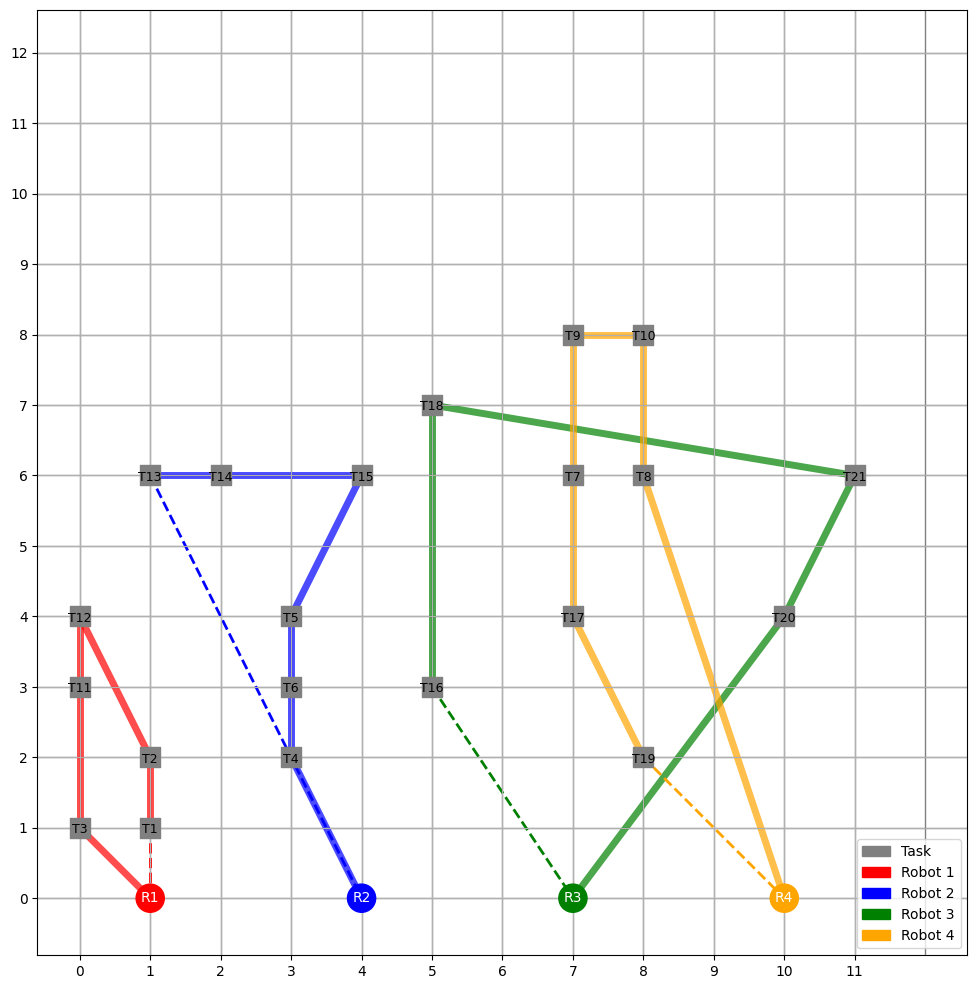

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Placeholder function for A*; replace with actual A* function
def a_star(start, goal):
    # This function should return a list of (x, y) tuples as the path from 'start' to 'goal'
    # Here it returns a direct line for illustration
    return [start, goal]

# Settings
grid_size = (12, 14)
robot_colors = ['red', 'blue', 'green', 'orange']
task_marker = 's'  # Square for tasks
robot_marker = 'o'  # Circle for robots
path_alpha = 0.7  # Transparency for paths

# Create figure and axes
fig, ax = plt.subplots(figsize=(grid_size[0], grid_size[1]))
ax.set_xticks(range(grid_size[0]))
ax.set_yticks(range(grid_size[1]))
plt.grid(True)

# Draw grid
for x in range(grid_size[0] + 1):
    ax.axhline(x, lw=1, color='grey', zorder=0)
    ax.axvline(x, lw=1, color='grey', zorder=0)

# Plot tasks with labels
for i, pos in enumerate(task_pos):
    ax.scatter(pos[0], pos[1], c='grey', s=200, marker=task_marker, label='Task' if i == 0 else "", zorder=2)
    ax.text(pos[0], pos[1], f'T{i+1}', fontsize=9, ha='center', va='center_baseline', zorder=3)

robot_patches = []  # Keep track of robot patches for the legend
for idx, (pos, color) in enumerate(zip(robot_pos, robot_colors)):
    robot_patch = patches.Circle(pos, 0.2, color=color, label=f'Robot {idx+1}', zorder=4)
    ax.add_patch(robot_patch)
    robot_patches.append(robot_patch)
    ax.text(*pos, f'R{idx+1}', color='white', ha='center', va='center', zorder=5)

# Draw paths from each robot to each task in sequence
for robot_index in set(robots):
    task_sequence = [pair[0] for pair in pairs if pair[1] == robot_index]

    # Initial position of the robot
    start = robot_pos[robot_index]

    # Draw paths for each task
    for task_num in task_sequence:
        # Destination task position
        end = task_pos[task_num]

        # Calculate path
        path = a_star(start, end)
        xs, ys = zip(*path)
        ax.plot(xs, ys, color=robot_colors[robot_index], linewidth=5, zorder=1, alpha=path_alpha)
        # Update the start position to the end of the last path
        start = end

    # Draw line between final task location and original robot position
    final_task_location = task_pos[task_sequence[-1]]
    ax.plot([final_task_location[0], robot_pos[robot_index][0]], [final_task_location[1], robot_pos[robot_index][1]],
            color=robot_colors[robot_index], linewidth=2, linestyle='--', zorder=1)

# Create a legend for tasks and robots
task_legend = patches.Patch(color='grey', label='Task')
plt.legend(handles=[task_legend] + robot_patches, loc='lower right')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()
